*Import* *library* yang dibutuhkan.

In [1]:
import os
import copy

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import optuna

import warnings
warnings.filterwarnings('ignore')
import gc
gc.enable()

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/datavidia2019/test.csv
/kaggle/input/datavidia2019/flight.csv
/kaggle/input/datavidia2019/Data Dictionary.pdf
/kaggle/input/datavidia2019/sample_submission.csv
/kaggle/input/datavidia2019/hotel.csv


## *Exploratory Data Analysis* (EDA)

In [2]:
# Muat data ke pd.DataFrame
flight_csv = pd.read_csv("/kaggle/input/datavidia2019/flight.csv")
test_csv = pd.read_csv("/kaggle/input/datavidia2019/test.csv")
submit_csv = pd.read_csv("/kaggle/input/datavidia2019/sample_submission.csv")

EDA dimulai dengan melihat beberapa data *train* (`flight_csv`) dan *test* (`test_csv`)

In [3]:
# Lihat 5 data train teratas
flight_csv.head()

,account_id,order_id,member_duration_days,gender,trip,service_class,price,is_tx_promo,no_of_seats,airlines_name,route,hotel_id,visited_city,log_transaction
0,912aa410a02cd7e1bab414214a7005c0,5c6f39c690f23650d3cde28e5b51c908,566.0,M,trip,ECONOMY,885898.00,NO,1.0,33199710eb822fbcfd0dc793f4788d30,CGK - DPS,None,"'['Semarang', 'Jakarta', 'Medan', 'Bali']'","'[545203.03, 918492.11, 1774241.4, 885898.0]'"
1,d64a90a618202a5e8b25d8539377f3ca,5cbef2b87f51c18bf399d11bfe495a46,607.0,M,trip,ECONOMY,2139751.25,NO,2.0,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Jakarta', 'Medan', 'Bali']'","'[555476.36, 2422826.84, 7398697.64, 7930866.8..."
2,1a42ac02bcb4a902973123323f84da55,38fc35a1e62384012a358ab1fbd5ad03,648.0,F,trip,ECONOMY,2695550.00,NO,1.0,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Semarang', 'Jakarta', 'Medan', 'Bali']'","'[7328957.45, 7027662.34, 1933360.88, 3461836...."
3,92cddd64d4be4dec6dfbcc0c50e902f4,c7f54cb748828b4413e02dea2758faf6,418.0,F,trip,ECONOMY,1146665.00,NO,1.0,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Jogjakarta', 'Bali', 'Jakarta', 'Medan']'","'[5243631.69, 2474344.48, 1146665.0]'"
4,bf637abc47ea93bad22264f4956d67f6,dec228e4d2b6023c9f1fe9cfe9c451bf,537.0,F,trip,ECONOMY,1131032.50,NO,1.0,6c483c0812c96f8ec43bb0ff76eaf716,CGK - DPS,None,"'['Jakarta', 'Bali', 'Medan', 'Jogjakarta', 'S...","'[9808972.98, 9628619.79, 6712680.0, 5034510.0..."


In [4]:
# Lihat 5 data test teratas
test_csv.head()

,account_id,order_id,member_duration_days,gender,trip,service_class,price,is_tx_promo,no_of_seats,airlines_name,route,visited_city,log_transaction
0,89a5fadd4d596610ff56044b9a0b1f4f,5ca64fd80a069208e3c0aa05dd580fb8,1754,M,trip,ECONOMY,3143400.00,YES,3,e35de6a36d385711a660c72c0286154a,CGK - DPS,"'['Bali', 'Jakarta', 'Medan']'","'[568508.04, 245284.05, 748834.2, 7930226.7, 6..."
1,86b28323bec6d938d47cee887e509b28,aca60904549a8a5958fe7a642efcb534,1084,F,trip,ECONOMY,2166607.04,NO,2,e35de6a36d385711a660c72c0286154a,CGK - DPS,"'['Medan', 'Bali', 'Jakarta']'","'[9916349.28, 7404847.79, 4697159.89, 2166607...."
2,36ef956ac3ef963c48e67327a4b6cc78,1771011e3adec5db9f30d15b3d439711,2378,M,round,ECONOMY,1239615.00,NO,1,ad5bef60d81ea077018f4d50b813153a,CGK - DPS,"'['Jakarta', 'Medan', 'Bali']'","'[249468.18, 1854801.11, 3311742.08, 4002723.4..."
3,f7821289404d44db50eb2edd4f82ea5b,6fc1b7d590c2a8c539ce56397403194d,576,F,trip,ECONOMY,1984060.00,YES,2,33199710eb822fbcfd0dc793f4788d30,CGK - DPS,"'['Jakarta', 'Bali', 'Medan', 'Jogjakarta', 'S...","'[6137034.61, 58939.21, 1984060.0]'"
4,f62f33d1de5aabc919b69b1b5697f27a,c1f4712f60cd758e773555690d148764,862,F,trip,ECONOMY,2990624.00,YES,1,74c5549aa99d55280a896ea50068a211,CGK - DPS,"'['Bali', 'Jakarta', 'Medan']'","'[9653724.83, 6417438.6, 2990624.0]'"


In [5]:
# Lihat 5 data submisi teratas
submit_csv.head()

,order_id,is_cross_sell
0,5ca64fd80a069208e3c0aa05dd580fb8,yes
1,aca60904549a8a5958fe7a642efcb534,yes
2,1771011e3adec5db9f30d15b3d439711,yes
3,6fc1b7d590c2a8c539ce56397403194d,yes
4,c1f4712f60cd758e773555690d148764,yes


Dari deskripsi kompetisi, variabel target yang akan diprediksi dari data *test* adalah `is_cross_sell`, dimana jika nilai pada fitur `hotel_id` tidak sama dengan `"None"`, maka nilai `is_cross_sell=1` (kelas positif), sebaliknya `is_cross_sell=0` (kelas negatif).<br>

Pertama, *copy* data ke variabel baru untuk diinspeksi. Ubah nilai pada fitur `hotel_id` ke bentuk biner.

In [6]:
# Copy data ke variabel baru untuk diinspeksi
ins_df = copy.copy(flight_csv)
# Ubah nilai pada fitur hotel_id ke biner
ins_df['hotel_id'] = ins_df['hotel_id'].apply(lambda x: 1 if x!="None" else 0).astype(np.uint8)

Berikut adalah fungsi bantuan untuk membuat plot.

In [7]:
# Fungsi untuk melihat proporsi nilai unik yang ada di suatu fitur
def countplot(feat="", train=None, test=None, fig=None, ax=None):
    try:
        ax1 = ax[0]
        test_flag = True
    except:
        ax1 = ax
        test_flag = False
    sns.countplot(y=feat, ax=ax1, data=train, order=train[feat].value_counts().index)
    for p in ax1.patches:
        value = p.get_width()/train.shape[0]
        if(p.get_width()/ax1.get_xlim()[1] >= 0.8):
            xloc = -5
            clr = 'white'
            align = 'right'
        else:
            xloc = 5
            clr = 'black'
            align = 'left'
        yloc = p.get_y()+p.get_height()/2
        ax1.annotate('{:.2%}'.format(value), xy=(p.get_width(), yloc), xytext=(xloc, 0),
                    textcoords="offset points",ha=align, va='center',
                    color=clr, weight='bold', clip_on=True)
    ax1.set_title('Countplot '+ feat +' [Train]')
    if(test_flag):
        sns.countplot(y=feat, ax=ax[1], data=test, order=train[feat].value_counts().index)
        for p in ax[1].patches:
            value = p.get_width()/test.shape[0]
            if(p.get_width()/ax[1].get_xlim()[1] >= 0.8):
                xloc = -5
                clr = 'white'
                align = 'right'
            else:
                xloc = 5
                clr = 'black'
                align = 'left'
            yloc = p.get_y()+p.get_height()/2
            ax[1].annotate('{:.2%}'.format(value), xy=(p.get_width(), yloc), xytext=(xloc, 0),
                        textcoords="offset points",ha=align, va='center',
                        color=clr, weight='bold', clip_on=True)
        ax[1].set_title('Countplot '+ feat +' [Test]')
    plt.show()
    return

def distplot(feat="", train=None, test=None, fig=None, ax=None):
    try:
        ax1 = ax[0]
        test_flag = True
    except:
        ax1 = ax
        test_flag = False
    sns.distplot(train[feat], ax=ax1)
    ax1.set_title('Distplot '+ feat + ' [Train]')
    if(test_flag):
        sns.distplot(test[feat], ax=ax[1])
        ax[1].set_title('Distplot '+ feat + ' [Test]')
    plt.show()
    return

Berikut adalah plot proporsi antara jumlah kelas positif dan jumlah kelas negatif. Dari semua data *train* yang ada, hanya sekitar **5.72%** data yang memiliki kelas positif. Ini artinya data tersebut memiliki *imbalance* pada target.<br>

Perlu ada perlakuan khusus baik terhadap data atau model untuk membuat prediksi yang baik. Salah satu perlakuan yang akan dipakai disini adalah mengubah nilai parameter `scale_pos_weight` pada beberapa jenis model seperti `XGBClassifier` (XGBoost), `LGBMClassifier` (LightGBM), atau `CatBoostClassifier` (Catboost). Parameter ini mengatur *weight* dari prediksi model ke kelas positif, sehingga semakin besar nilainya, maka prediksi semakin condong ke kelas positif.

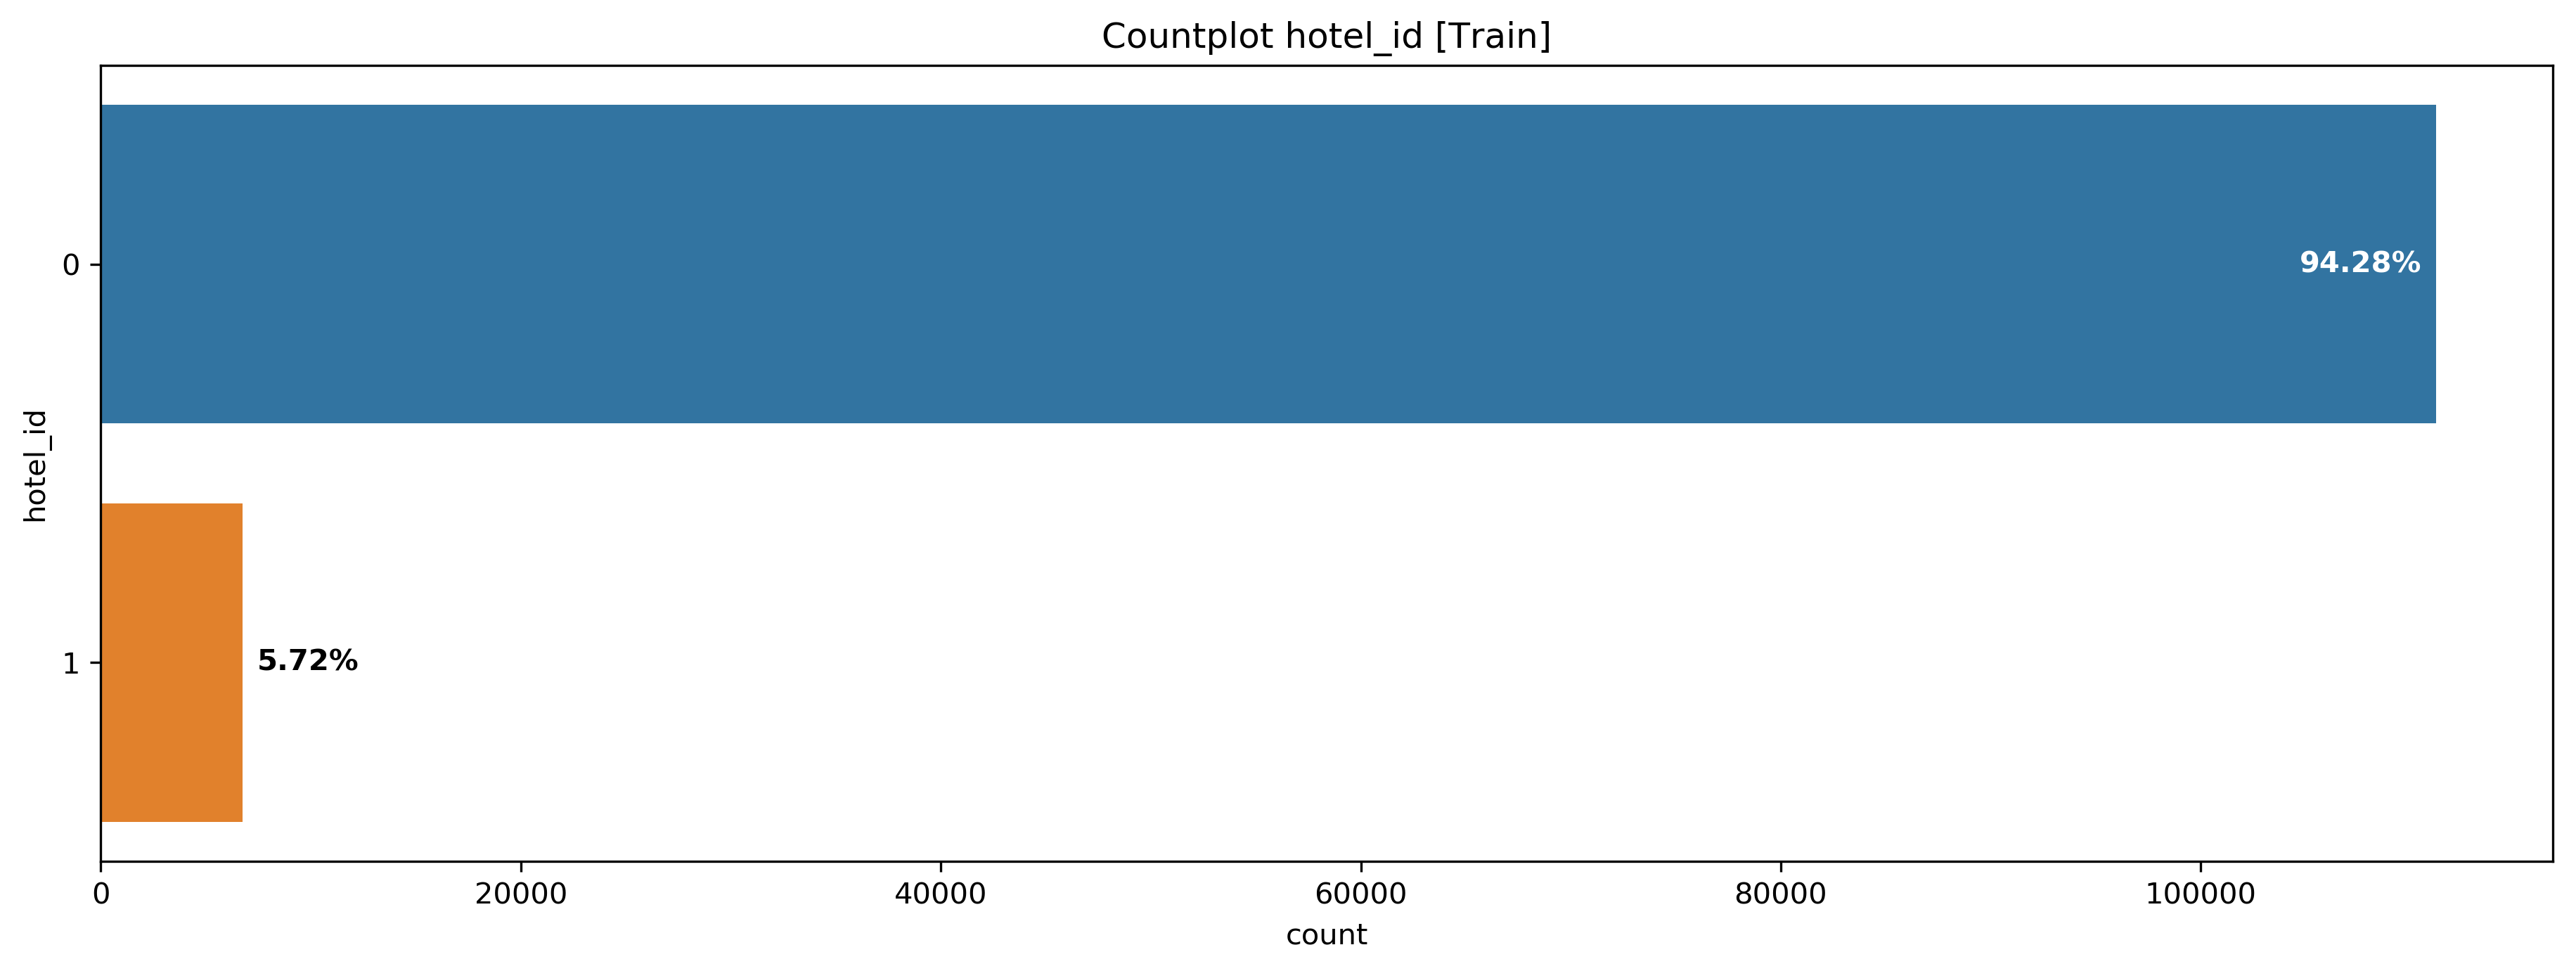

In [8]:
fig, ax = plt.subplots(1, figsize=(15, 5), dpi=300)
countplot(feat="hotel_id", train=ins_df, test=None, fig=fig, ax=ax)

Berikut akan ditampilkan fitur-fitur yang ada pada data melalui fungsi `info()` dari `DataFrame`. Dari sini juga dapat dilihat bahwa tidak ada *missing value* baik di data *train* maupun *test*.

In [9]:
print(ins_df.info())
print()
print(test_csv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117946 entries, 0 to 117945
Data columns (total 14 columns):
account_id              117946 non-null object
order_id                117946 non-null object
member_duration_days    117946 non-null float64
gender                  117946 non-null object
trip                    117946 non-null object
service_class           117946 non-null object
price                   117946 non-null float64
is_tx_promo             117946 non-null object
no_of_seats             117946 non-null float64
airlines_name           117946 non-null object
route                   117946 non-null object
hotel_id                117946 non-null uint8
visited_city            117946 non-null object
log_transaction         117946 non-null object
dtypes: float64(3), object(10), uint8(1)
memory usage: 11.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
account_id              10000 non-null object
order

Fitur `account_id` adalah *identifier* dari *customer* yang terdaftar di sistem. Dari hasil penghitungan nilai unik yang ada di fitur `account_id`, terlihat bahwa satu nilai `account_id` dapat memiliki beberapa transaksi (*row*). Hal ini mungkin dapat dimanfaatkan dari sisi seberapa sering suatu `account_id` melakukan *cross sell*. 

Karena itu, fitur ini akan digunakan untuk membangun model dengan harapan dapat memberikan informasi yang penting untuk memprediksi kelas. Fitur ini akan menajdi jenis fitur **kategorik nominal**.

In [10]:
# Lihat nilai unik yang ada di fitur account_id
print(ins_df['account_id'].value_counts())
print()
print(test_csv['account_id'].value_counts())

d64a90a618202a5e8b25d8539377f3ca    3311
fbb4123bb341ad85719af86930a0ccea     311
bf637abc47ea93bad22264f4956d67f6     161
74b423f5354172076e9529debf8866ac     145
4944140d10e202e845f0766a3e3ac2d1     133
                                    ... 
e20bb9e78d337d19d8b9849b0a4cce73       1
01e428459c4dcb6115bb9c0f6118a456       1
5e2d1e1998ca7f67a9a97b66835ae029       1
85d96b3754d51c2c77c5fa9cadc64e8c       1
d8d5994b0ccad38a831426082cd6e3e7       1
Name: account_id, Length: 74796, dtype: int64

d64a90a618202a5e8b25d8539377f3ca    209
f7b64bbf8462b0d1a006af1a983c609d     26
fbb4123bb341ad85719af86930a0ccea     19
49aef087188299dca09278b382147b44     19
5634d6fd8d25ce0fd43b00a26d6dc17c     19
                                   ... 
e3fd9afa2b109b205395263968e5787a      1
9c48b41352c0f61068ae6053a35f8e36      1
19c5dfccbee57d06edbc98df27dec196      1
c7c09998679e0198aa624d61aac6a176      1
392884113f9b6f8d65f82286026a0657      1
Name: account_id, Length: 8724, dtype: int64


Fitur `order_id` adalah *identifier* dari *order* yang ada di sistem. Dari hasil penghitungan nilai uniknya, tidak ada satupun jenis `order_id` yang muncul lebih dari satu kali baik di data *train* maupun data *test*. 

Karena fitur ini dianggap tidak akan memberikan informasi yang penting untuk memperdiksi kelas, maka tidak digunakan.

In [11]:
# Ambil panjang dari set nilai unik order_id di data train + test
uniq_train = ins_df['order_id'].value_counts().index
uniq_test = test_csv['order_id'].value_counts().index
len_set = len(set(np.append(uniq_train, uniq_test, axis=0)))
# Jika panjangnya sama dengan jumlah data train dan test, maka semua nilai pada order_id unik
# (tidak muncul lebih dari 1 kali)
print(len_set == (ins_df.shape[0]+test_csv.shape[0]))

True


Fitur `member_duration_days` adalah berapa lama sebuah `account_id` terdaftar di sistem dalam hitungan hari. Distribusi nilai pada fitur `member_duration_days` tidak berbeda jauh antara data *train* dan *test*. Fitur ini akan dipakai dan menjadi fitur **numerik rasio**.

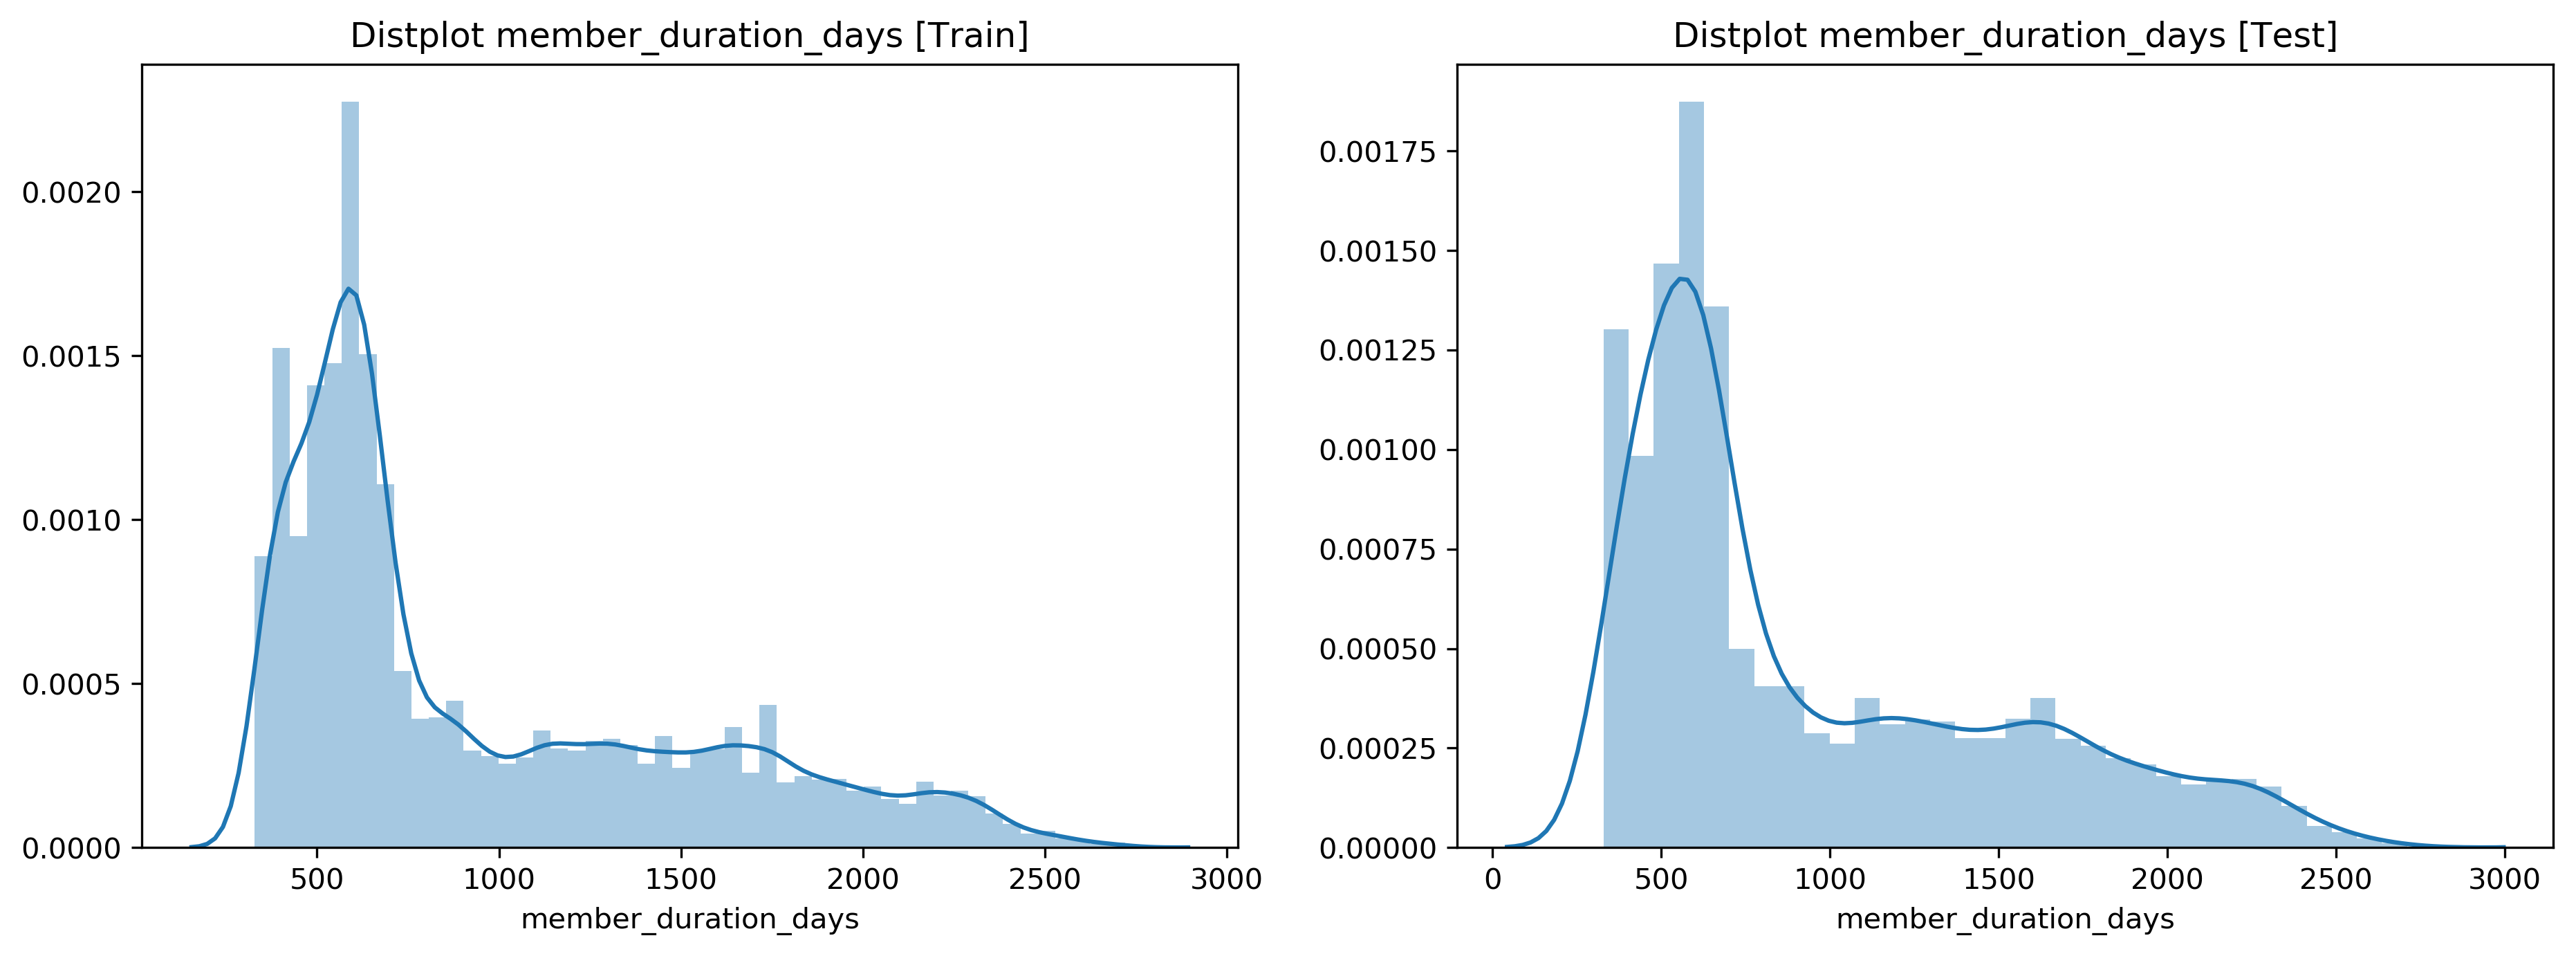

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
distplot(feat="member_duration_days", train=ins_df, test=test_csv, fig=fig, ax=ax)

Dari plot proporsi nilai pada fitur `gender`, dapat terlihat bahwa di data *train* ada beberapa sampel dengan nilai `gender` `"None"`, sedangkan di data *test* tidak ada. Sampel ini akan dihilangkan dari data *train*.

Fitur ini akan dipakai di pembuatan model dan menjadi jenis fitur **kategorik nominal**.

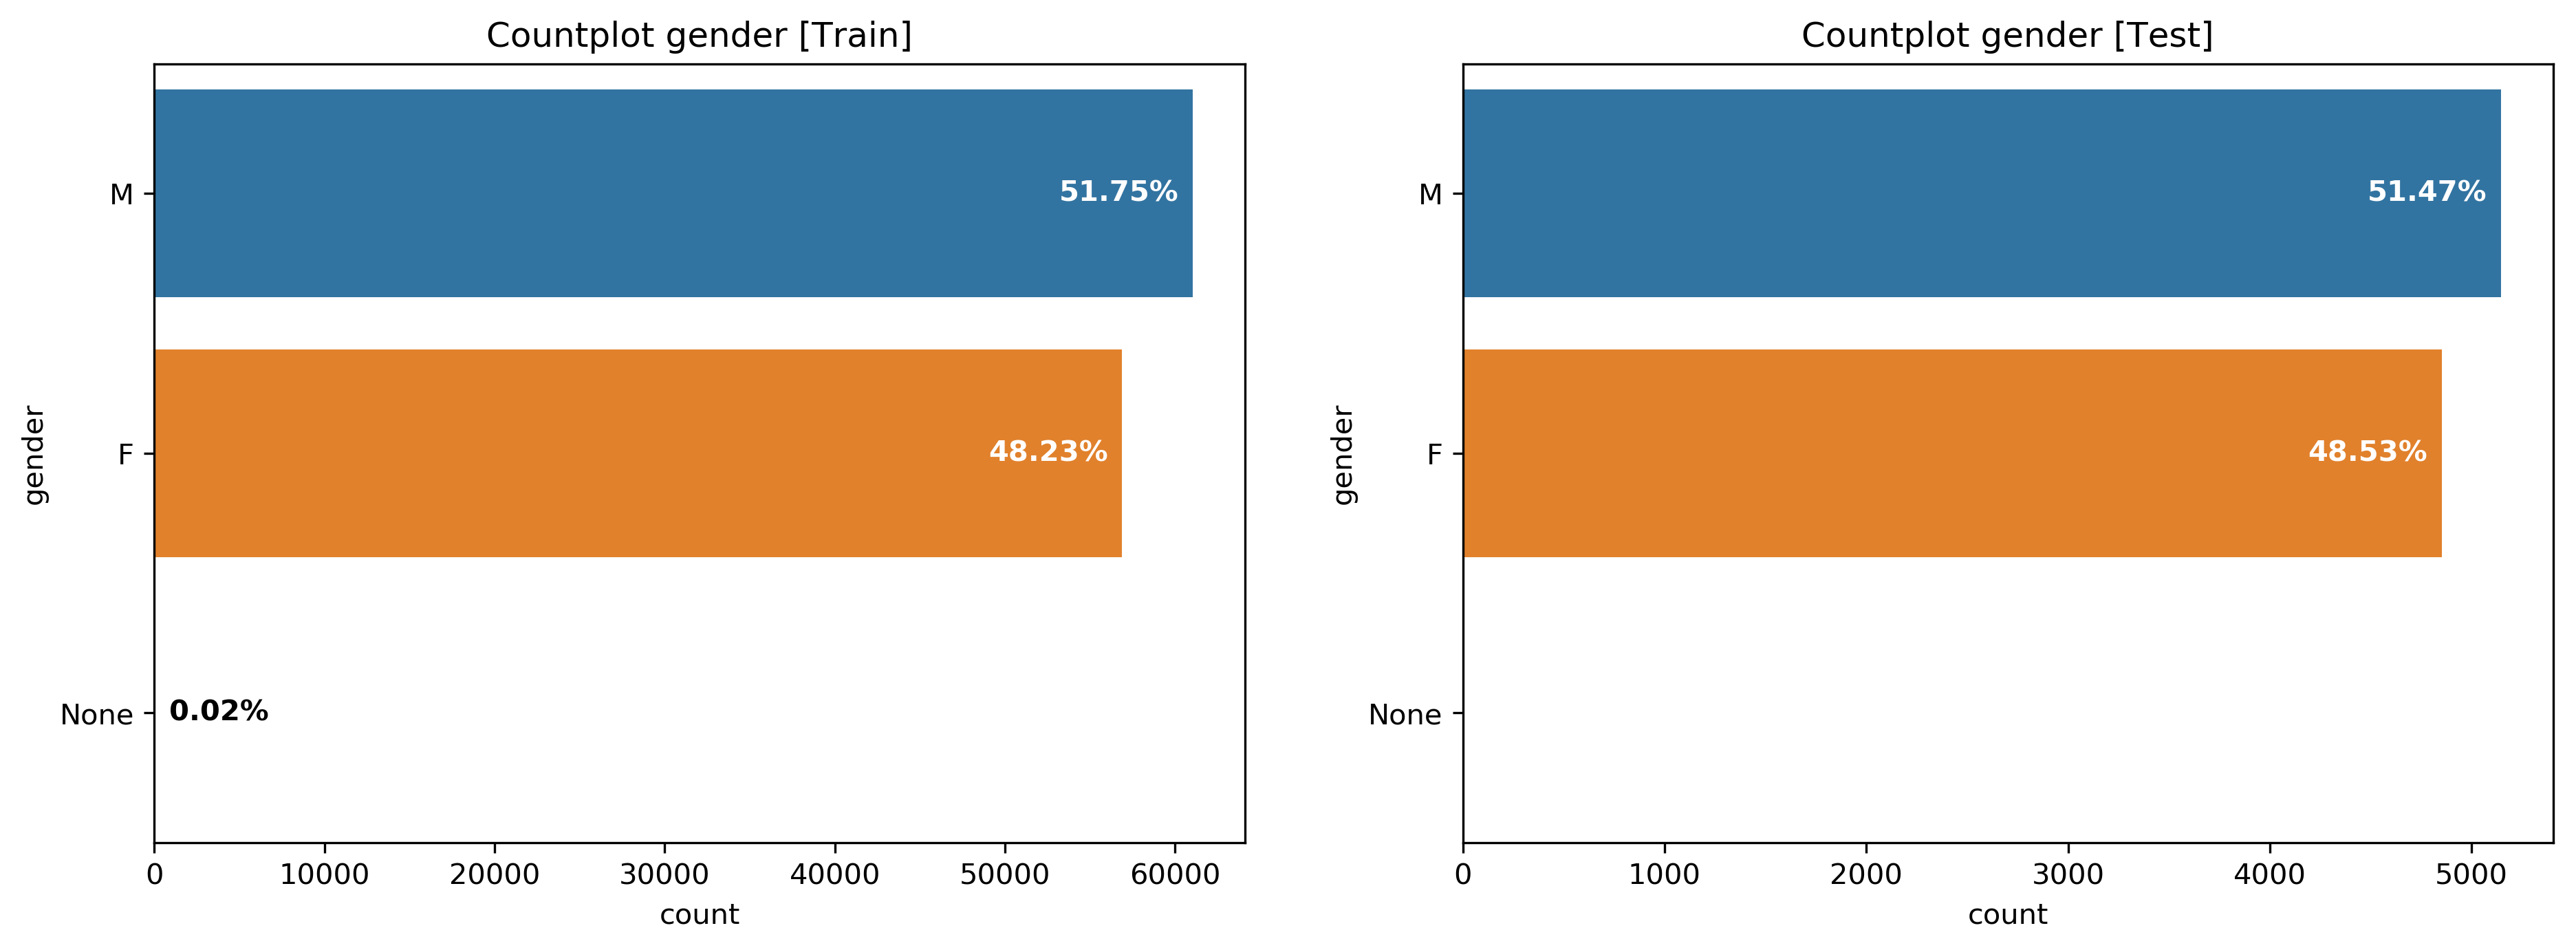

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
countplot(feat="gender", train=ins_df, test=test_csv, fig=fig, ax=ax)

Fitur `trip` adalah jenis *trip* dari *order* tiket yang dibuat. Proporsi nilai pada fitur `trip` hampir sama di *train* dan *test*. Fitur ini akan dipakai dan menjadi fitur **kategorik nominal**.

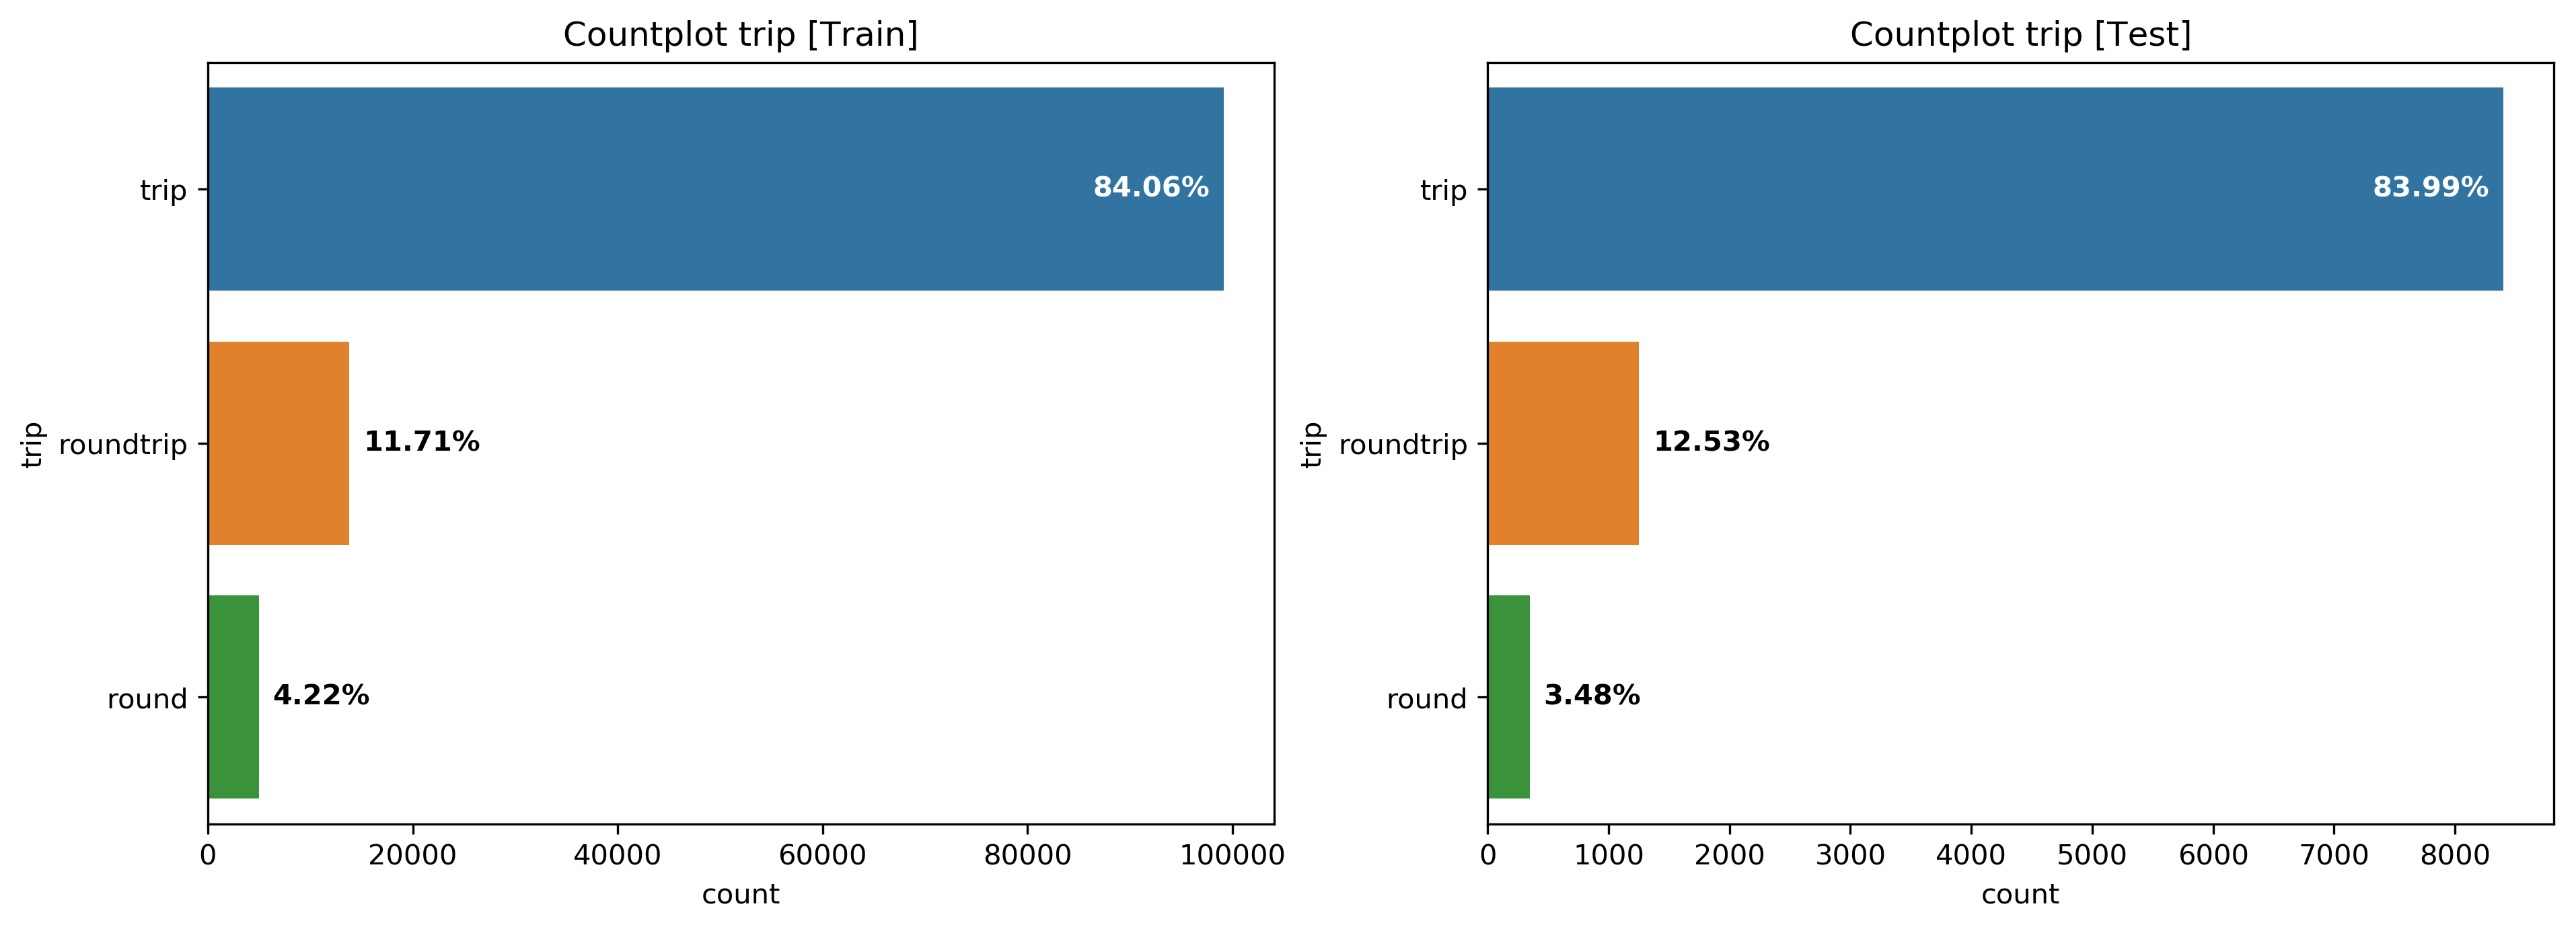

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
countplot(feat="trip", train=ins_df, test=test_csv, fig=fig, ax=ax)

Fitur `service_class` adalah jenis kelas penerbangan dari tiket yang dipesan. Proporsi nilai pada fitur `service_class` hampir sama di *train* dan *test* dengan nilai `"ECONOMY"` yang sangat mendominasi. Fitur ini akan dipakai dan menjadi fitur **kategorik nominal**.

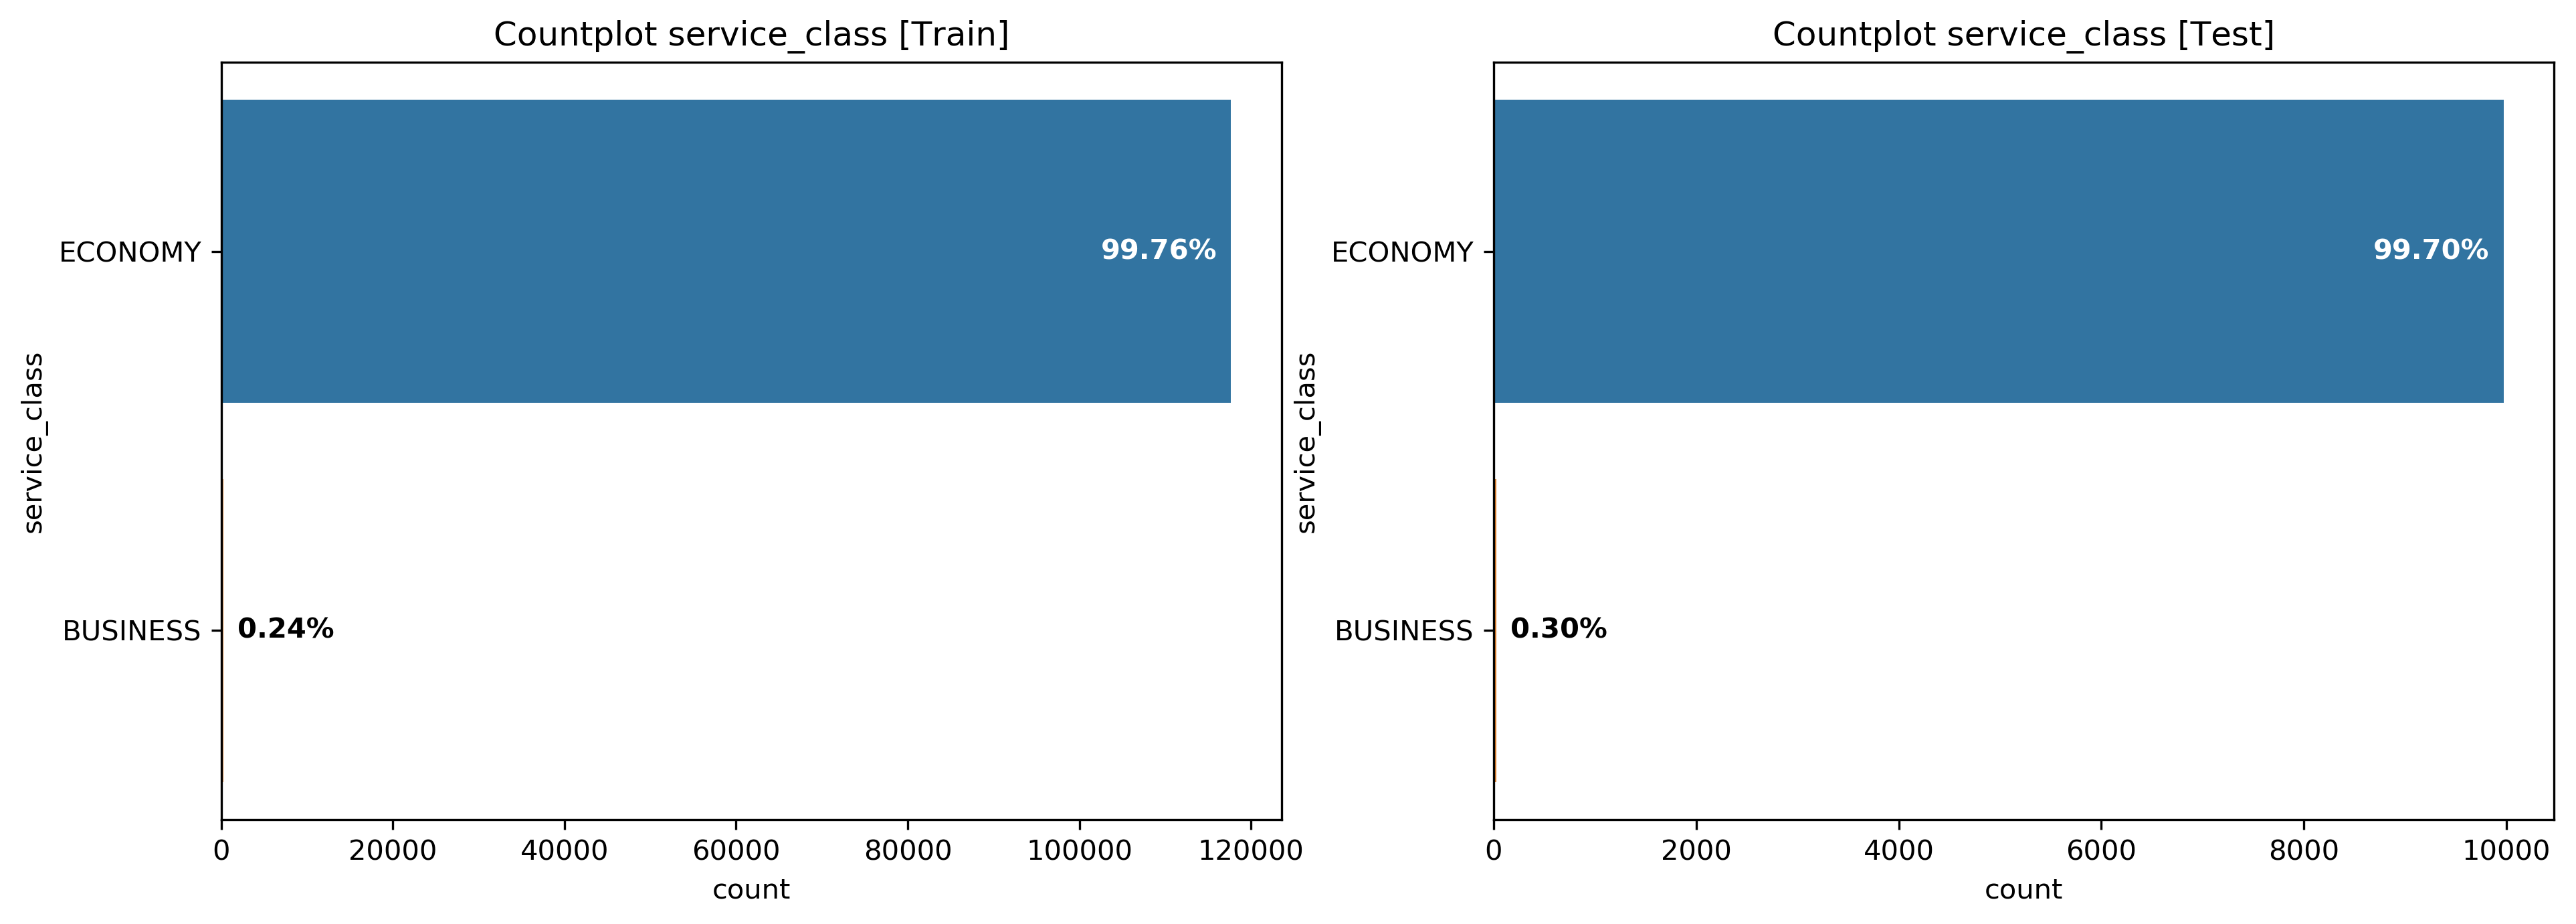

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
countplot(feat="service_class", train=ins_df, test=test_csv, fig=fig, ax=ax)

Fitur `price` adalah harga dari tiket pesawat. Proporsi nilai pada fitur `price` hampir sama di *train* dan *test* dengan sedikit nilai yang sangat besar (5x1e7 - 6x1e7) pada data *train*. Fitur ini akan dipakai dan menjadi fitur **numerik rasio**.

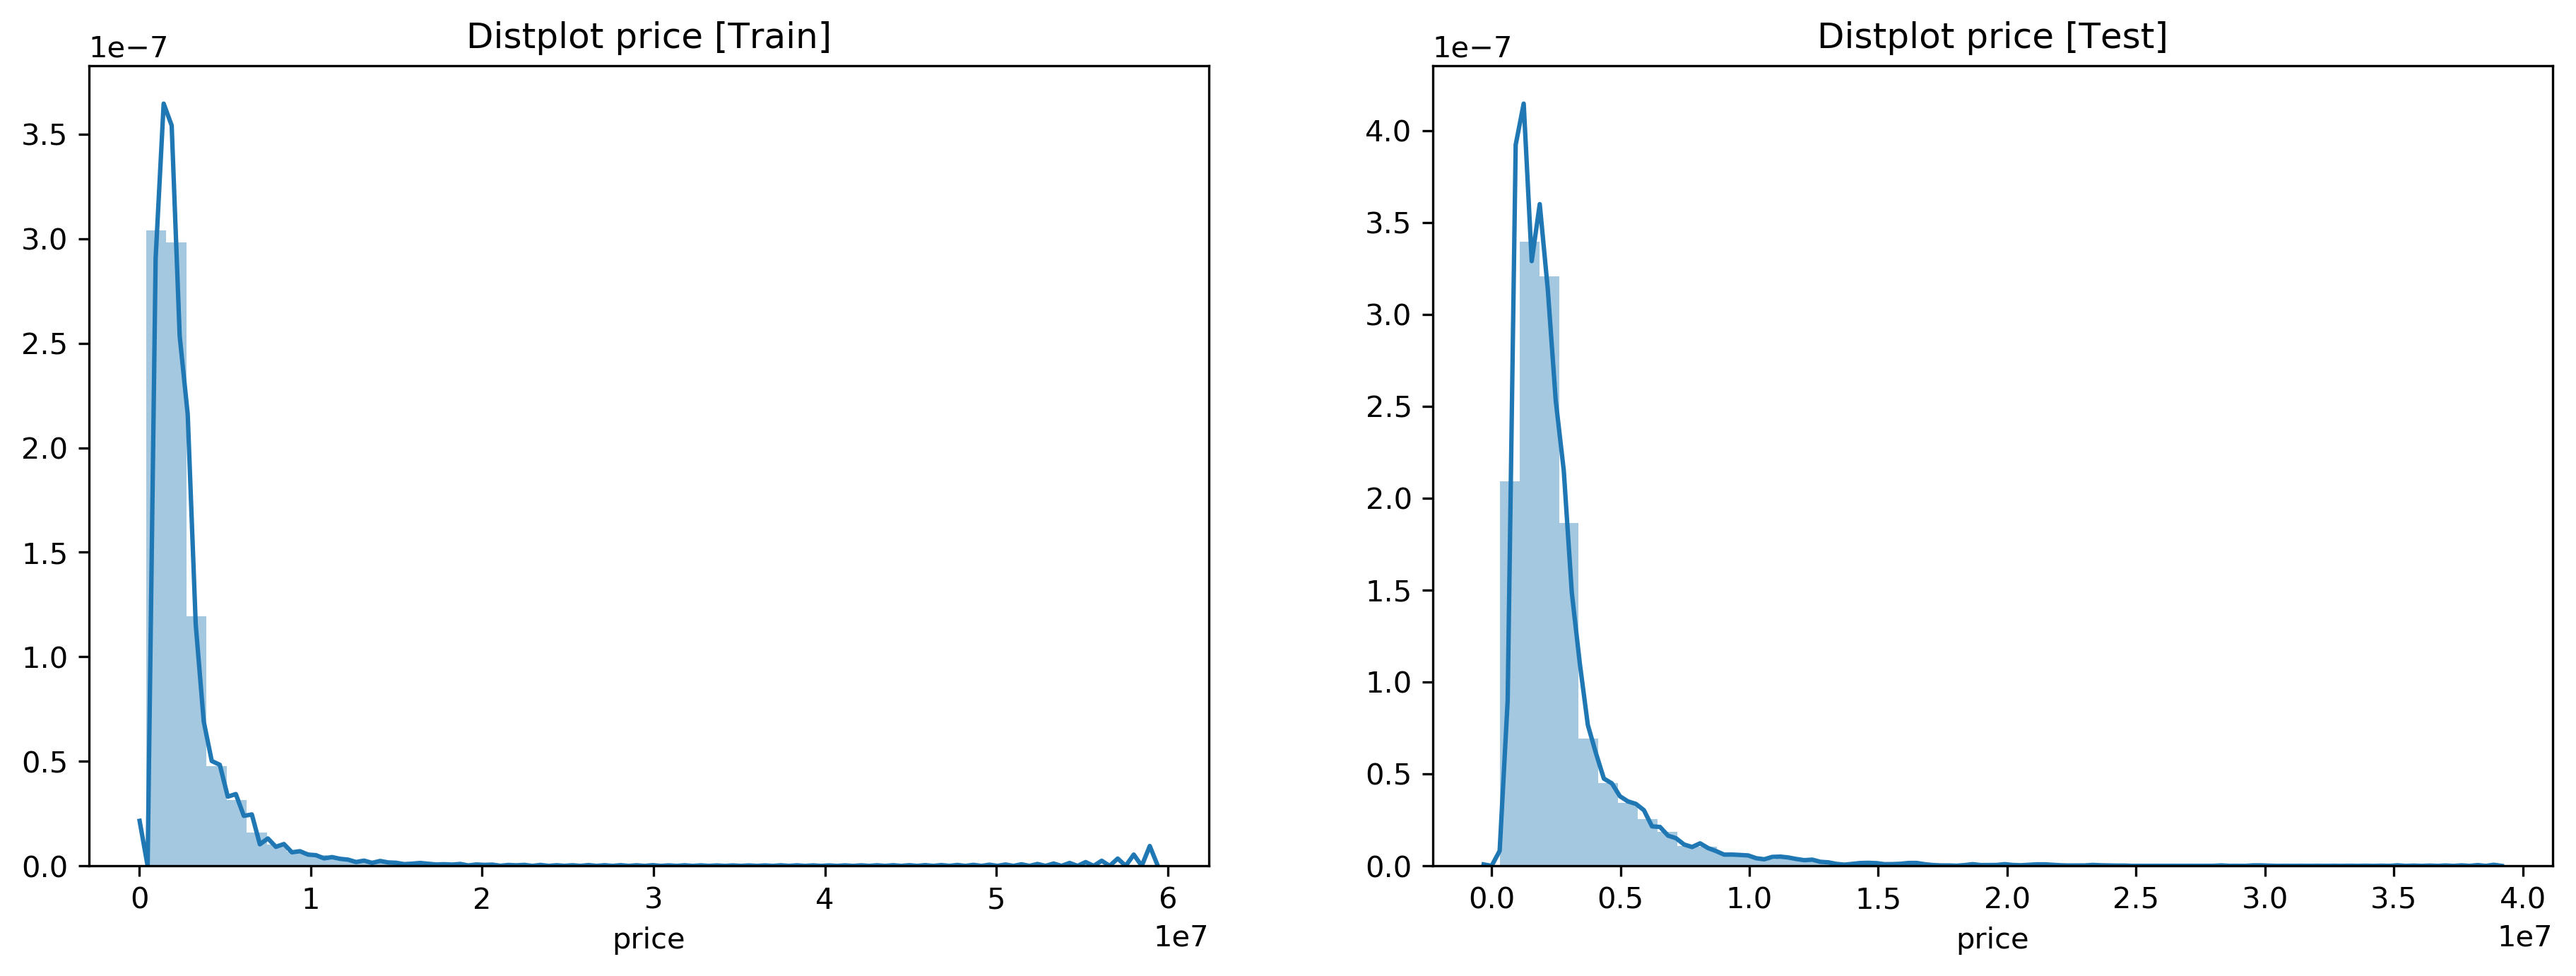

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
distplot(feat="price", train=ins_df, test=test_csv, fig=fig, ax=ax)

Fitur `is_tx_promo` adalah ada atau tidaknya promo di tiket yang dipesan. Proporsi nilai pada fitur `is_tx_promo` hampir sama di *train* dan *test*. Fitur ini akan dipakai dan menjadi fitur **kategorik nominal**.

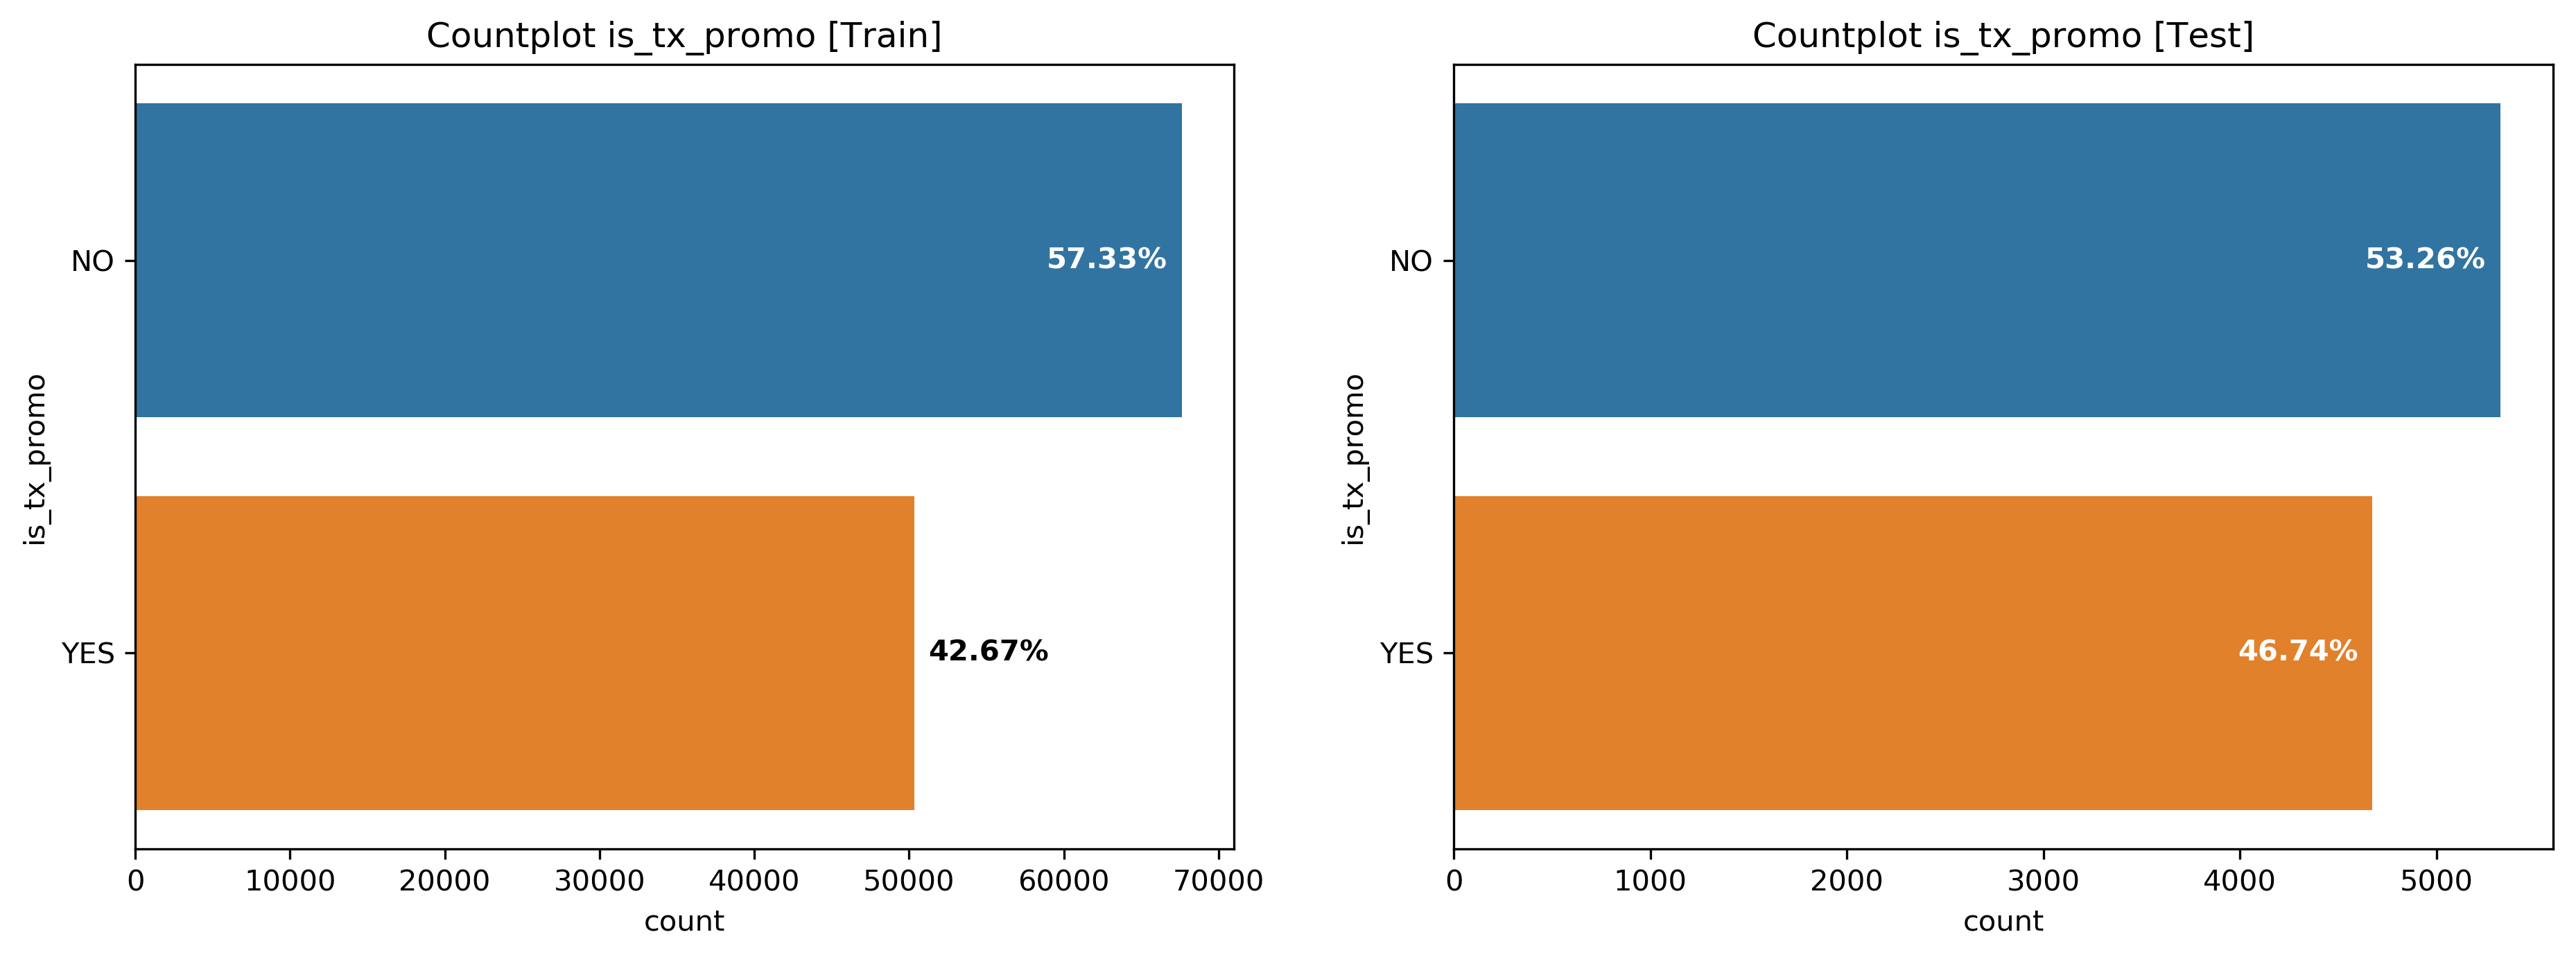

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
countplot(feat="is_tx_promo", train=ins_df, test=test_csv, fig=fig, ax=ax)

Fitur `no_of_seats` adalah jumlah *seat* yang dipesan. Terilhat bahwa di data *train* ada beberapa sampel dengan `no_of_seats=11`, sedangkan di *test* tidak ada. Sampel ini akan dihilangkan dari data *train*. 

Selebihnya, distribusi nilai terlihat sama antara data *train* dan *test*. Fitur ini akan dipakai dan menjadi fitur **numerik rasio**.

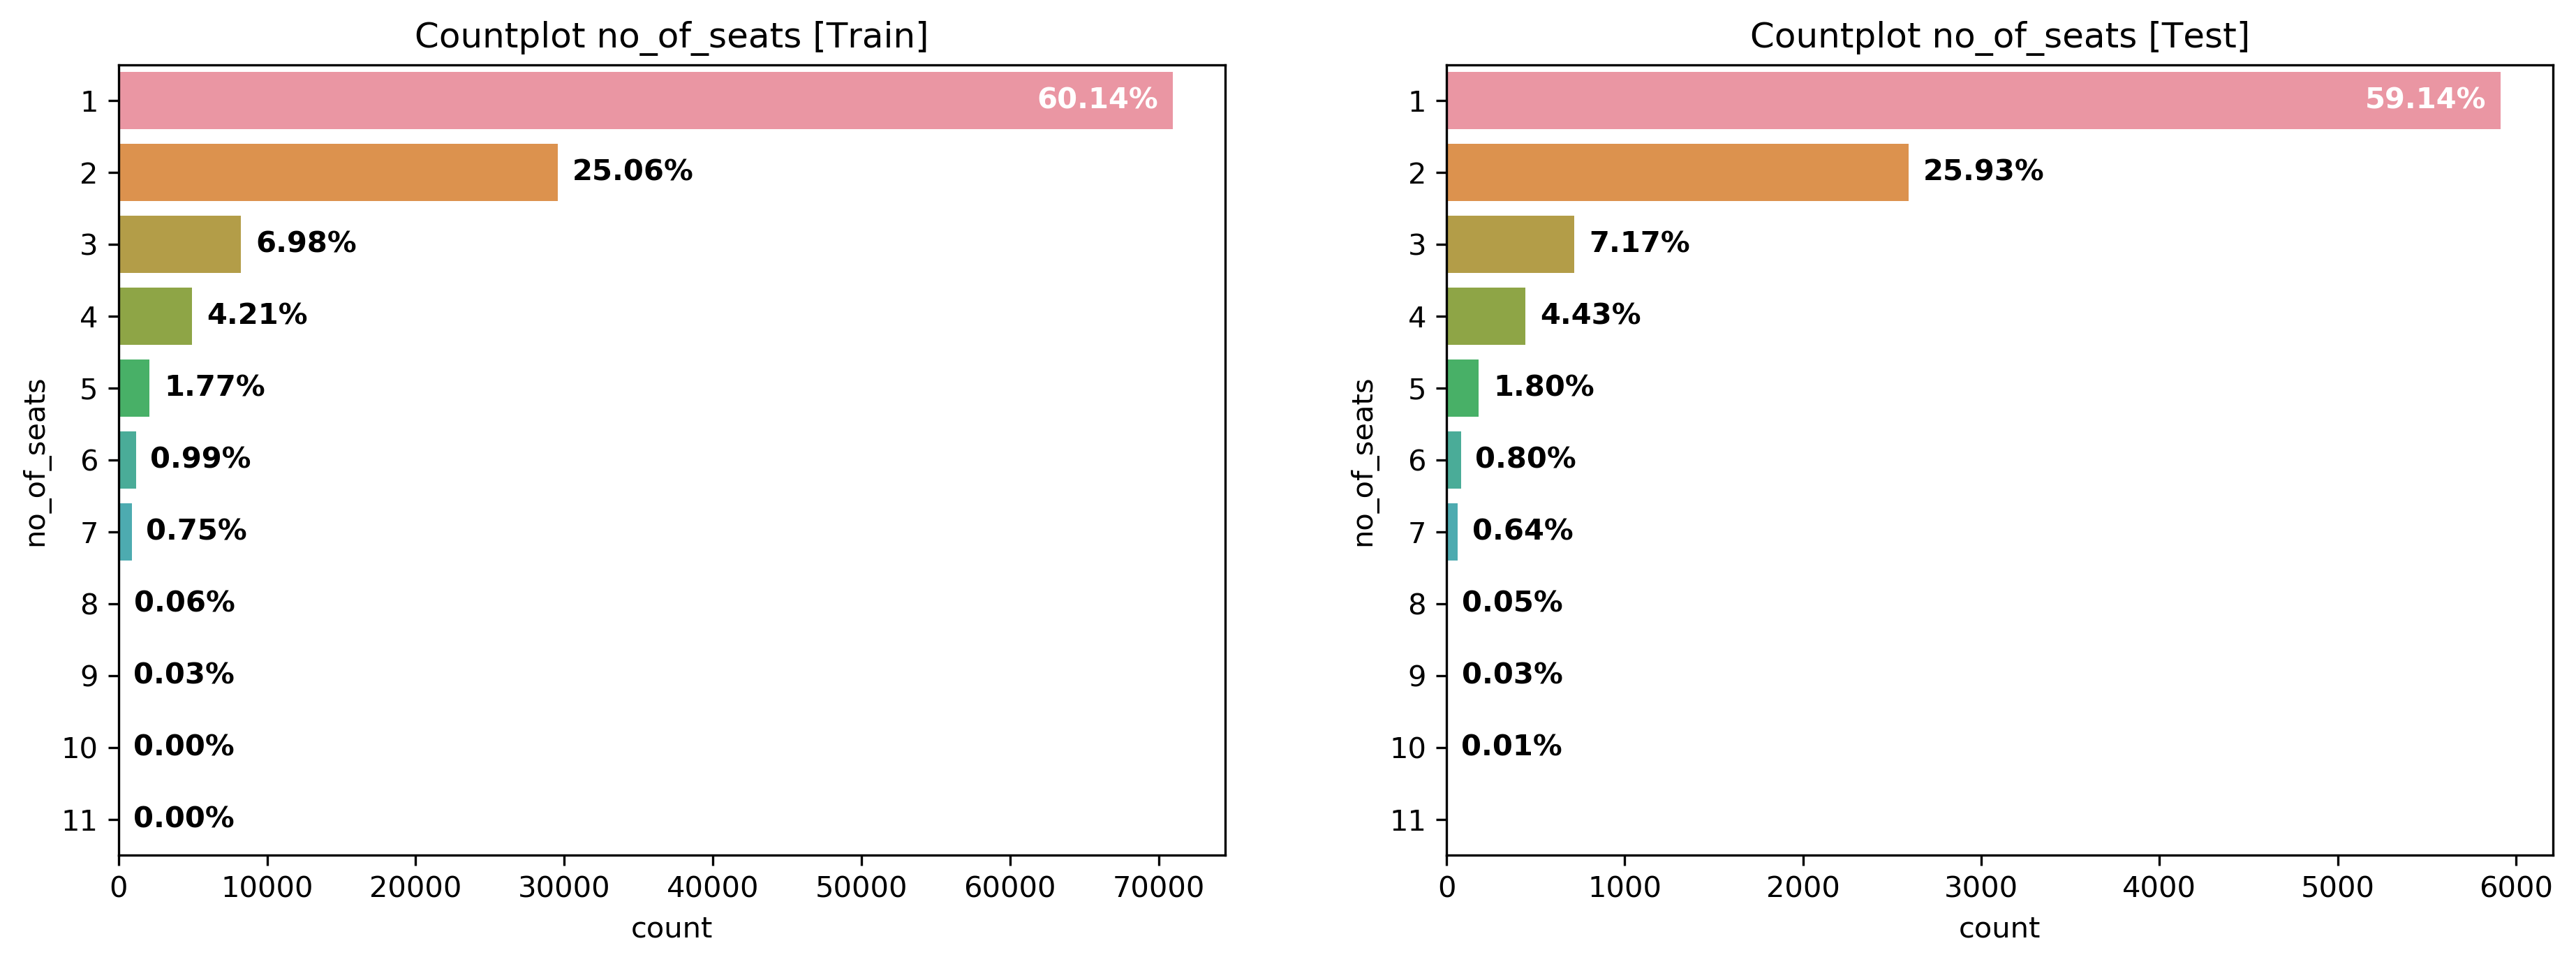

In [18]:
ins_df['no_of_seats'] = ins_df['no_of_seats'].astype(np.int32)
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
countplot(feat="no_of_seats", train=ins_df, test=test_csv, fig=fig, ax=ax)

Fitur `airlines_name` adalah nama penyedia penerbangan yang dipesan. Terilhat bahwa di data *train* ada beberapa sampel dengan nilai `"9855a1d3de1c46526dde37c5d6fb758c"` dan `"6872b49542519aea7ae146e23fab5c08"`, sedangkan di *test* tidak ada. Sampel  ini akan dihilangkan dari data *train*.

Selebihnya, distribusi nilai terlihat sama antara data *train* dan *test*. Fitur ini akan dipakai dan menjadi fitur **kategorik nominal**.

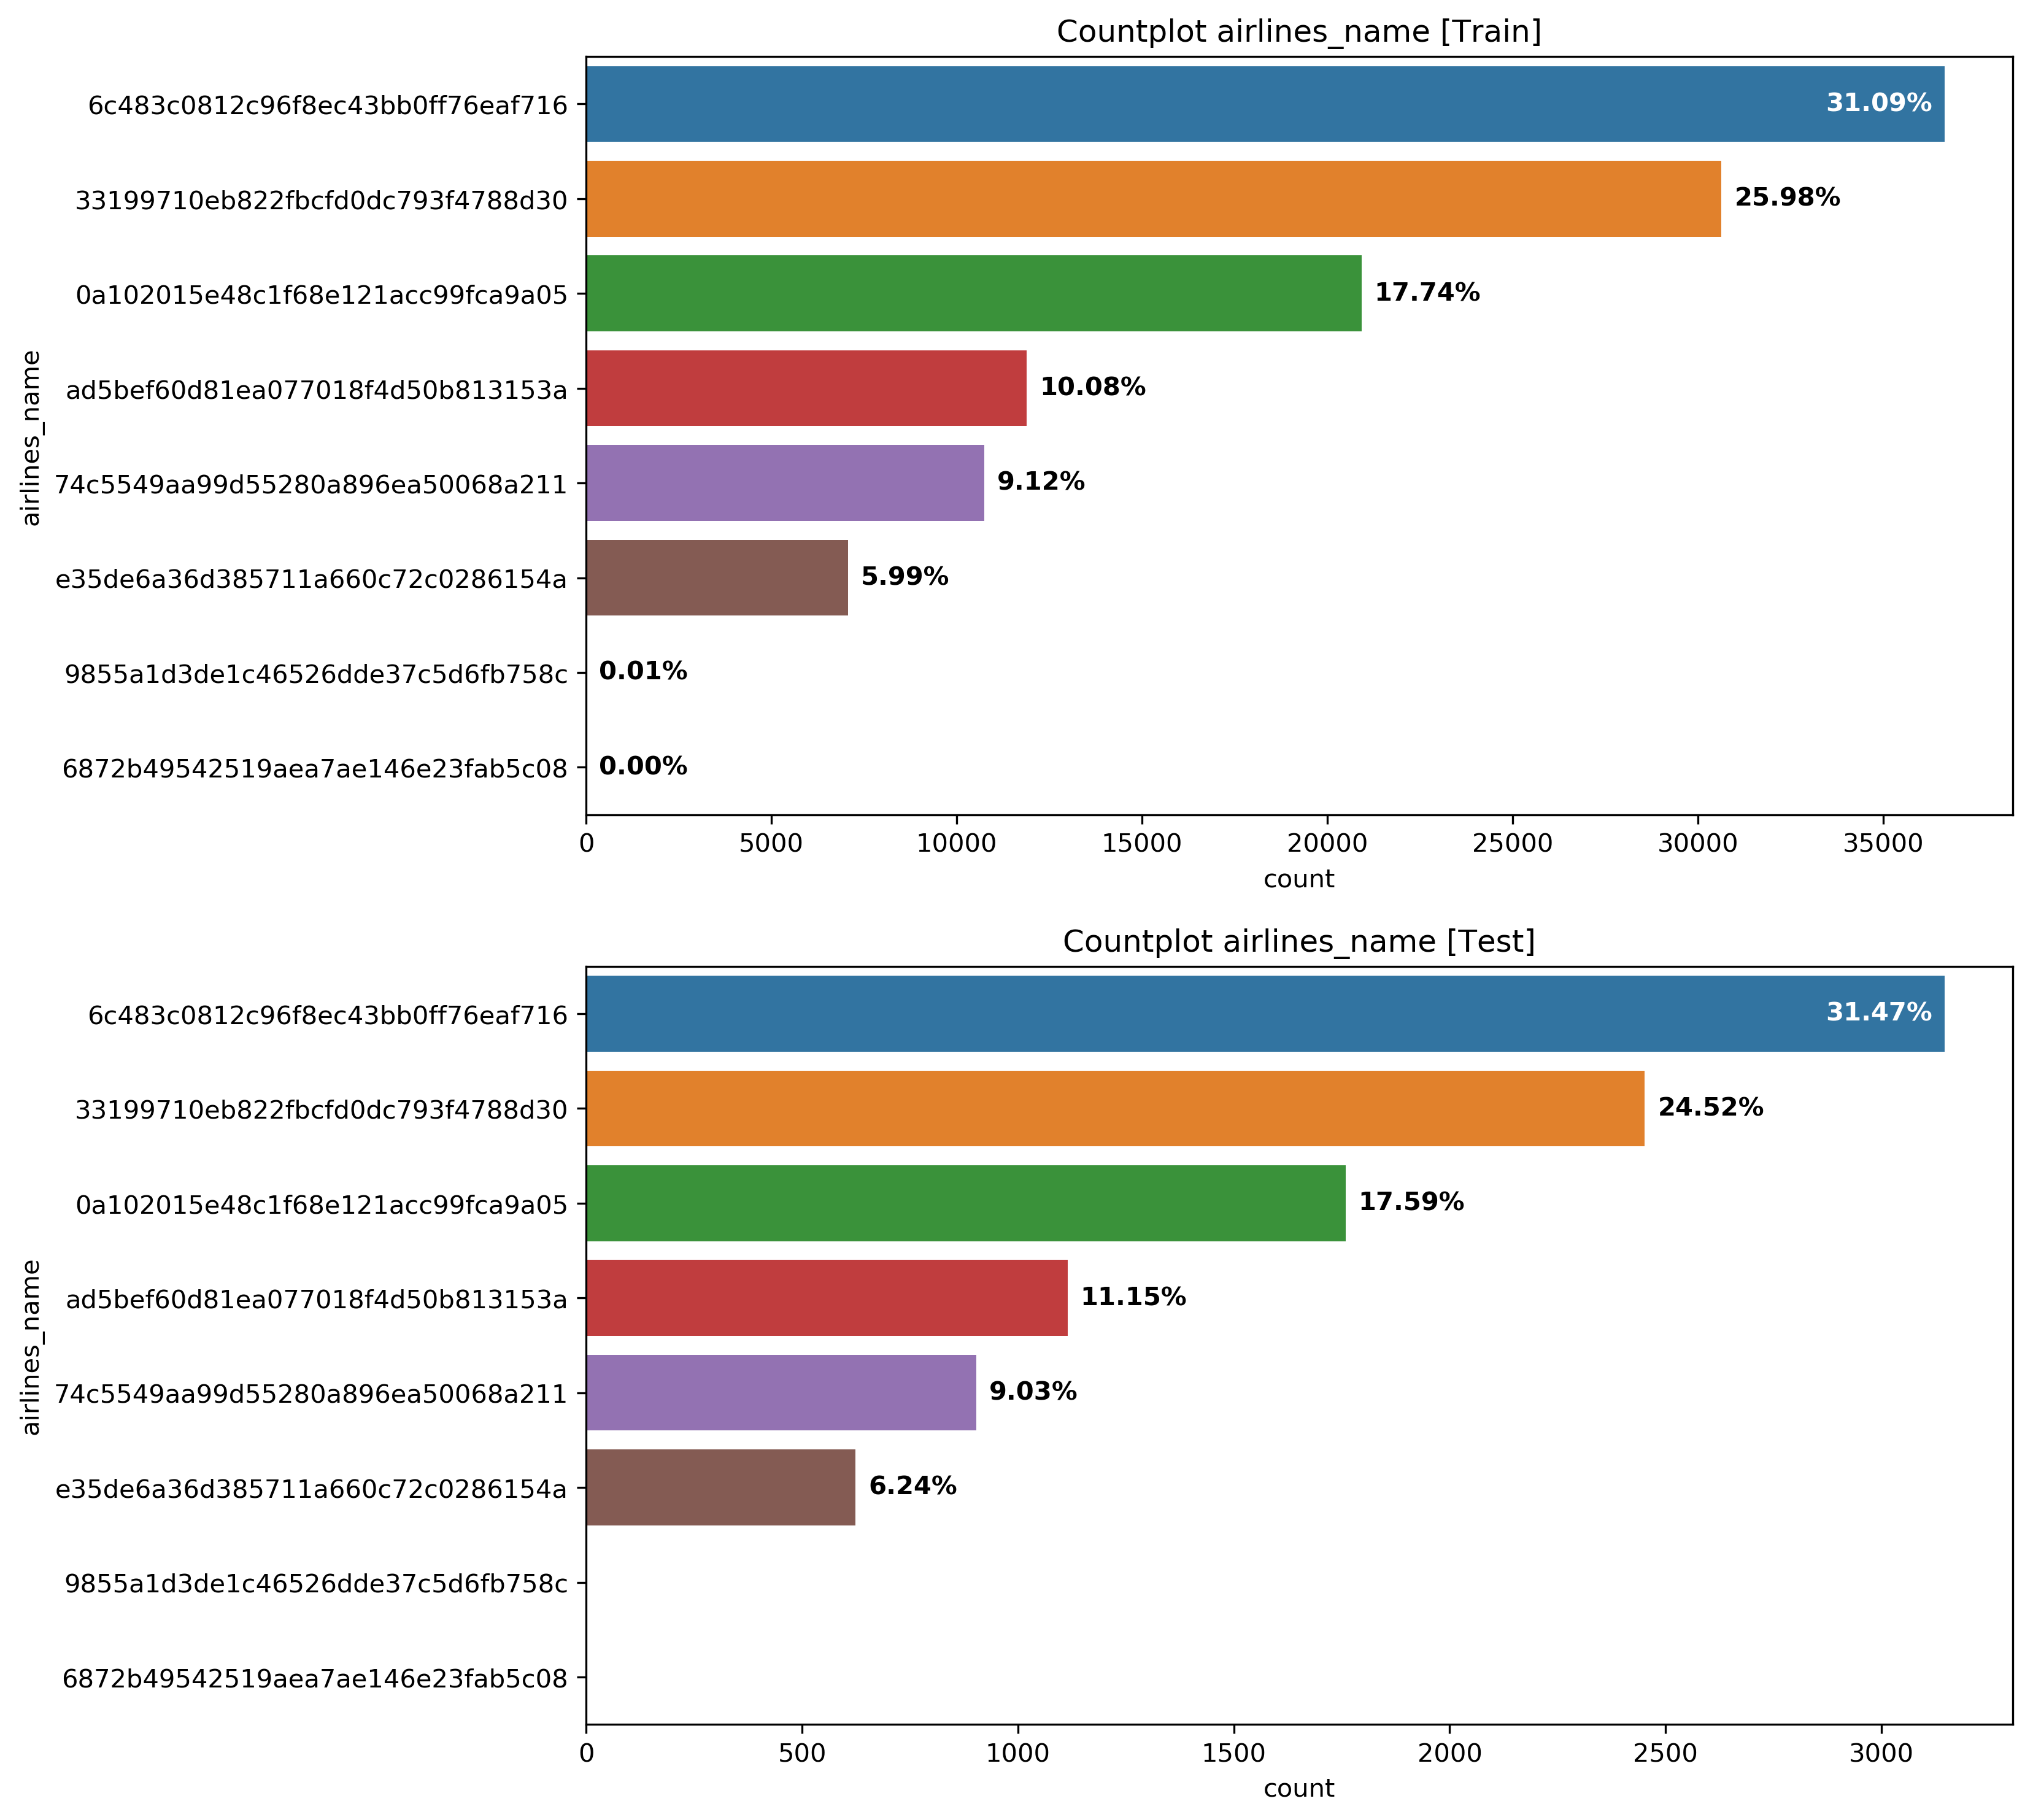

In [19]:
fig, ax = plt.subplots(2, figsize=(10, 12), dpi=300)
countplot(feat="airlines_name", train=ins_df, test=test_csv, fig=fig, ax=ax)

Fitur `route` adalah rute dari penerbangan. Terlihat hanya ada 1 nilai unik di data *train* dan *test*, `"CGK - DPS"`. Karena dianggap tidak memberikan informasi, maka fitur ini tidak dipakai.

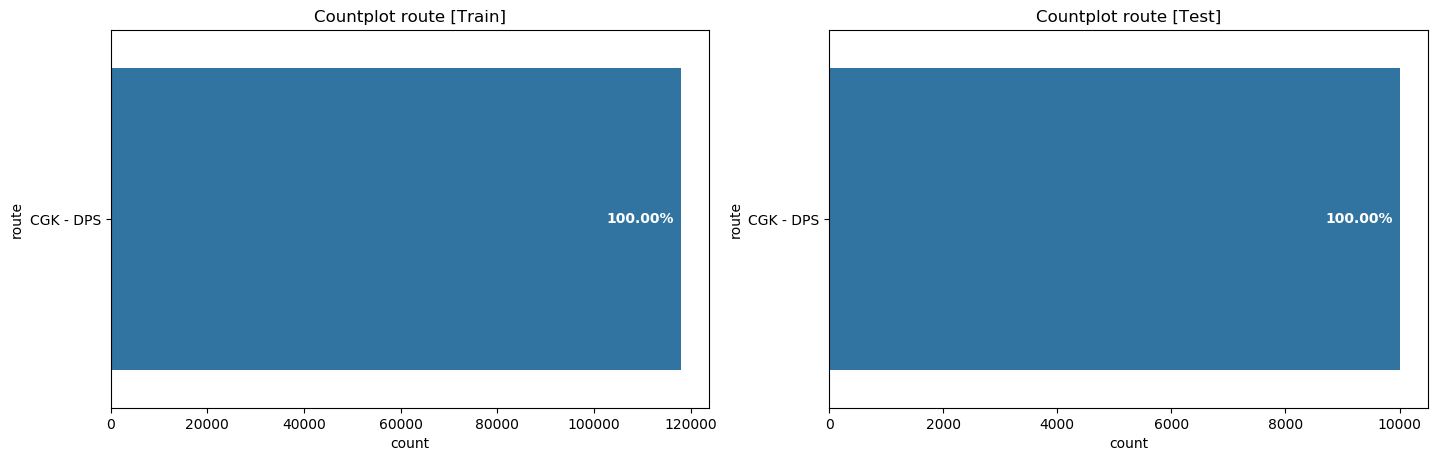

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5), dpi=100)
countplot(feat="route", train=ins_df, test=test_csv, fig=fig, ax=ax)

Fitur `visited_city` adalah *list* kota yang telah dikunjungi oleh *customer*.

Ada 8 kota unik yang berada di data yaitu 'Jakarta', 'Medan', 'Bali', 'Semarang', 'Jogjakarta', 'Surabaya', 'Aceh', dan 'Manado'. Selain itu, ada *list* yang memuat kota-kota yang sama namun urutannya berbeda, contohnya `'['Jakarta','Medan','Bali']'`, `'['Bali','Jakarta','Medan']'`, dan `'['Medan','Bali','Jakarta']'`. Urutan ini akan diekstraksi melalui cara tertentu yang akan dijelaskan di bagian *Feature Engineering*.

Distribusi nilai terlihat sama di data *train* dan *test*. Fitur ini akan dipakai dan menjadi fitur **kategorik nominal**.

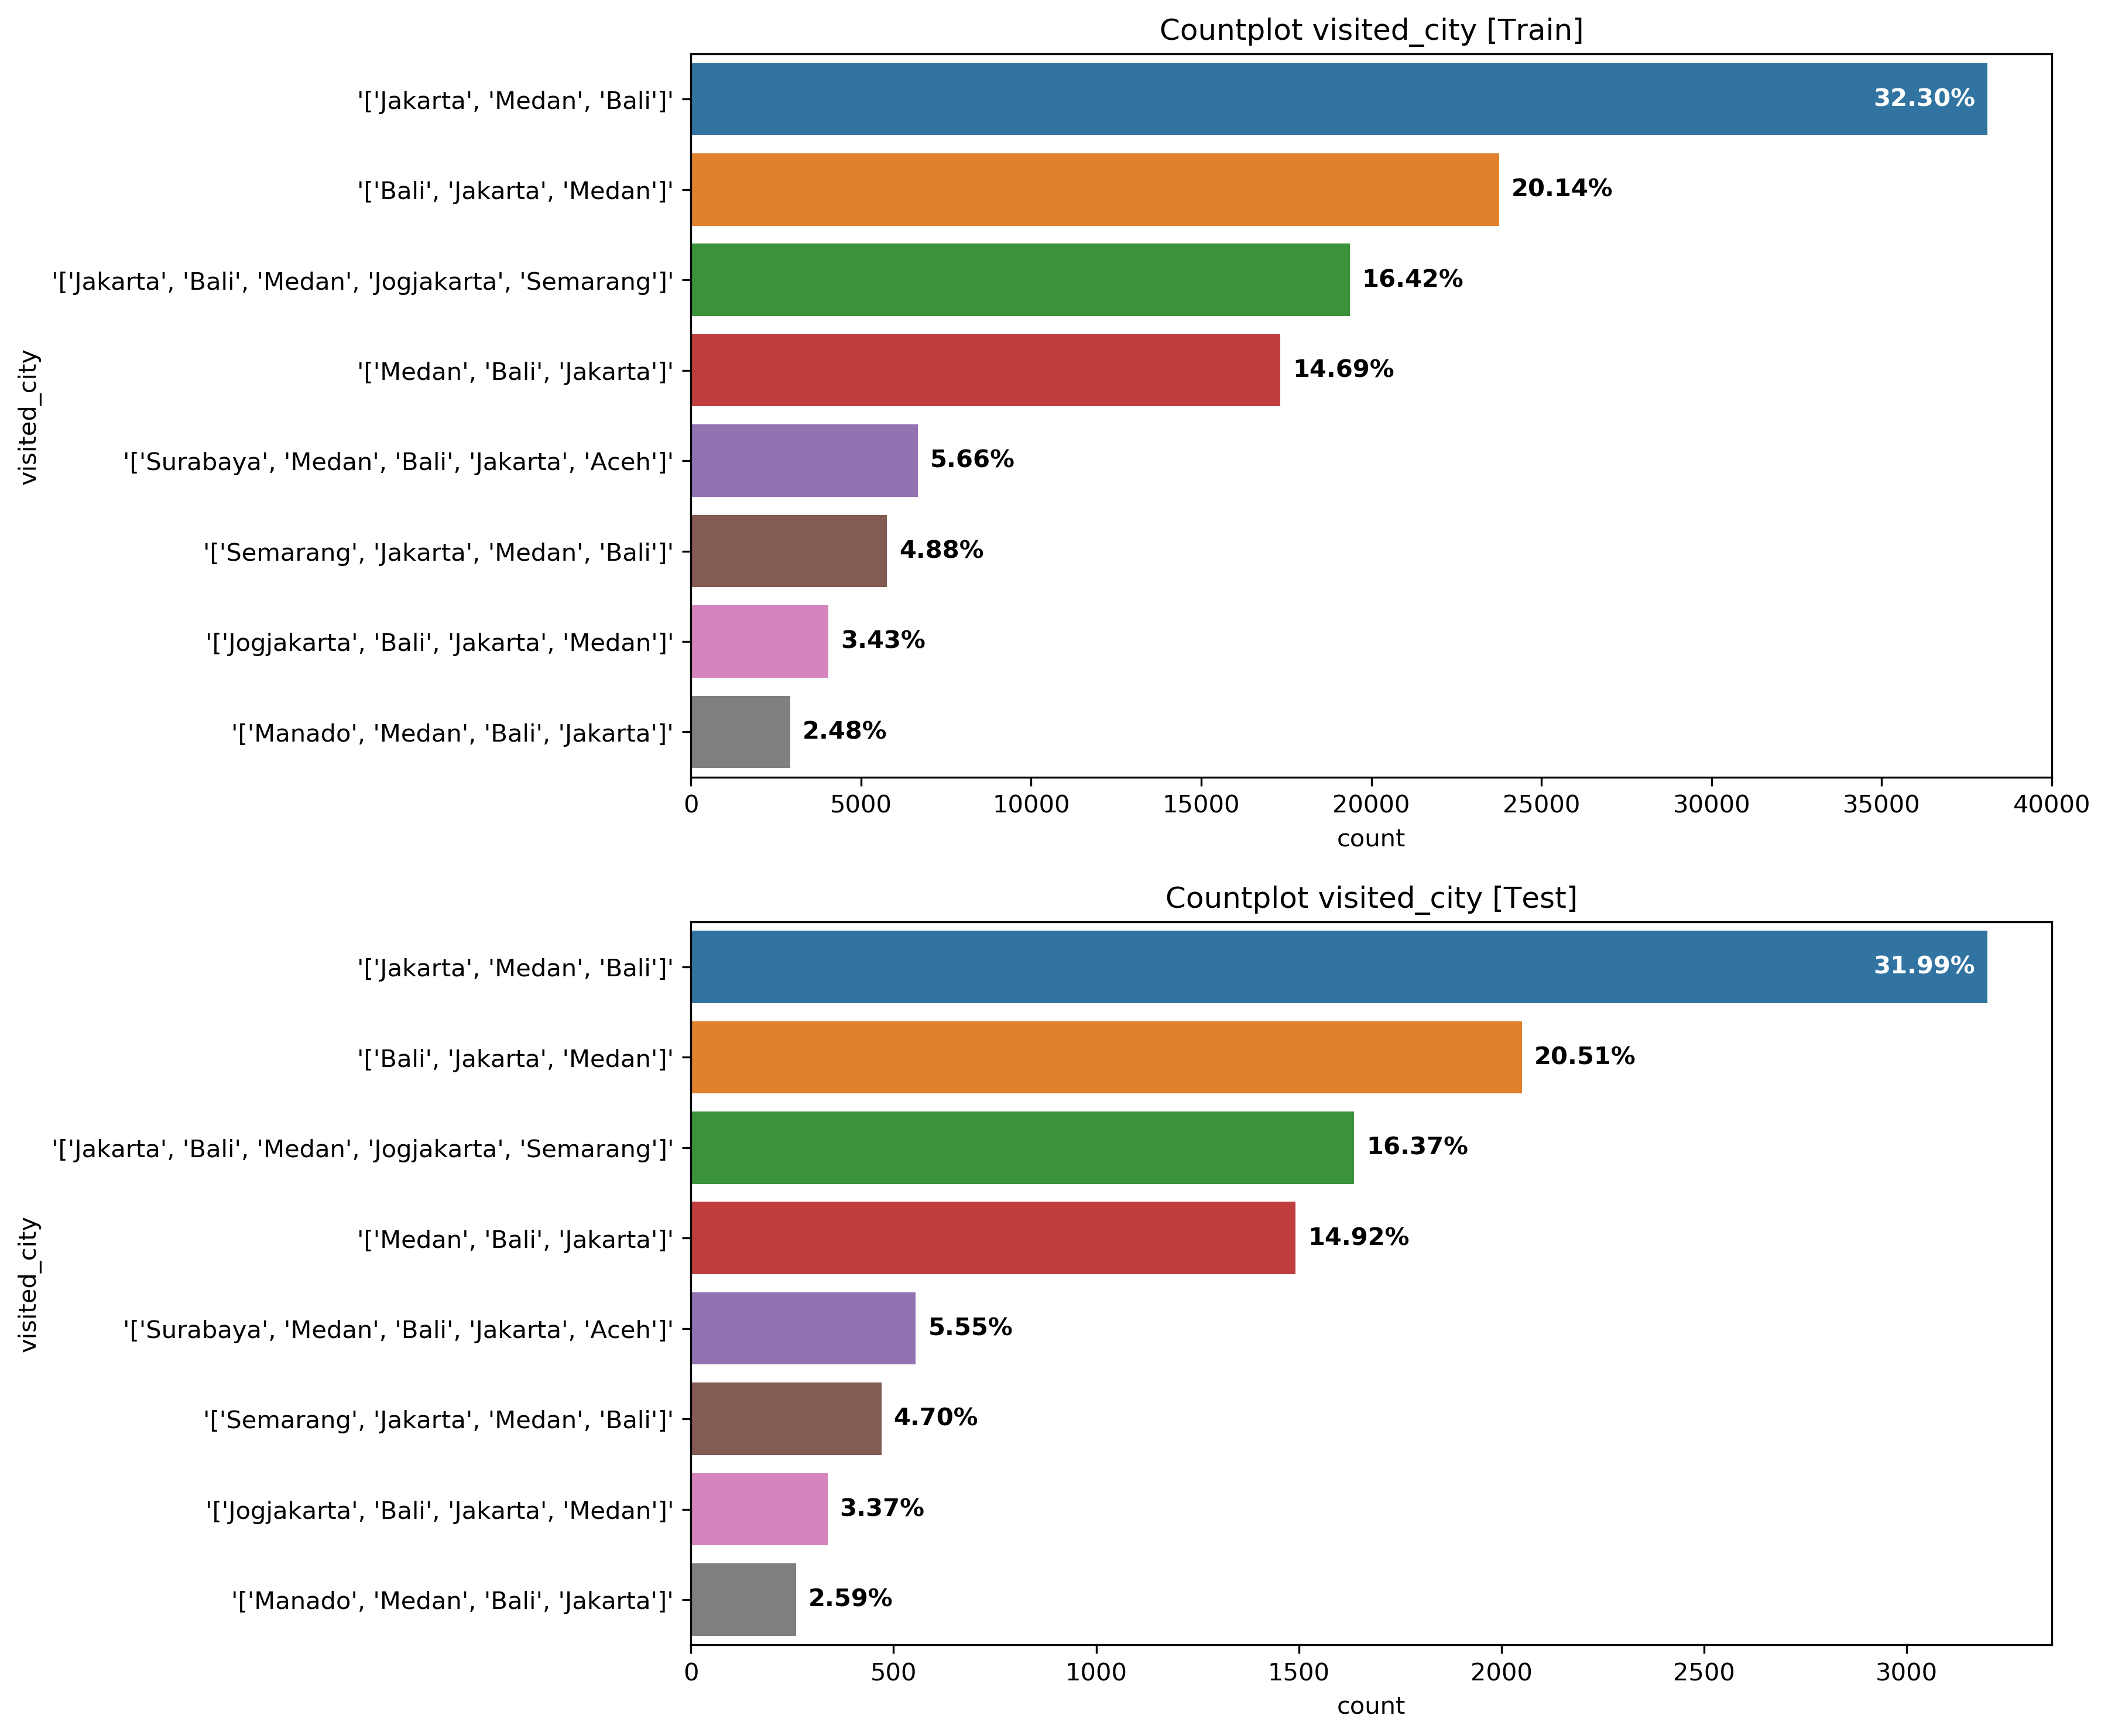

In [21]:
fig, ax = plt.subplots(2, figsize=(10, 12), dpi=300)
countplot(feat="visited_city", train=ins_df, test=test_csv, fig=fig, ax=ax)

Fitur `log_transaction` adalah *list* transaksi yang sudah dikeluarkan oleh *customer*. Dari inspeksi lebih lanjut, terlihat bahwa *list* ini memuat transaksi yang dikeluarkan pada **saat sekarang** ditambah **saat sebelumnya**. Contohnya dapat dilihat dibawah untuk `account_id='fbb4123bb341ad85719af86930a0ccea'`. 

Fitur ini akan dipakai dan diekstraksi untuk mengetahui *list* transaksi yang ada pada **saat sekarang** saat proses *Feature Engineering*.

In [22]:
# Ambil data dengan sebuah account_id
sub_df = ins_df[ins_df['account_id']=='fbb4123bb341ad85719af86930a0ccea']
# Urutkan data
sub_df = sub_df.sort_values(['log_transaction'], ascending=False)

In [23]:
# Lihat 4 transaksi teratas
print(sub_df['log_transaction'].iloc[0])
print(sub_df['log_transaction'].iloc[1])
print(sub_df['log_transaction'].iloc[2])
print(sub_df['log_transaction'].iloc[3])

'[9083304.1, 1620921.76, 6212861.86, 1236830.29, 3712420.08, 1747460.0]'
'[9083304.1, 1620921.76, 6212861.86, 1236830.29, 3712420.08, 1747460.0, 6989840.0]'
'[9083304.1, 1620921.76, 6212861.86, 1236830.29, 3712420.08, 1747460.0, 6989840.0, 1282710.0]'
'[9083304.1, 1620921.76, 6212861.86, 1236830.29, 3712420.08, 1747460.0, 6989840.0, 1282710.0, 2342340.0]'


Untuk fitur **numerik rasio**, tidak ada perlakuan/ekstraksi terhadap fitur tersebut. Sedangkan fitur dengan jenis **kategorik nominal** akan di-*encode* dengan skema **Target Encoding** (**TE**). Secara garis besar, hasil **TE** menggambarkan seberapa sering suatu nilai pada suatu fitur masuk ke kelas tertentu. *Detail* dan fungsinya akan lebih dijelaskan di sesi berikutnya.

## *Data Preprocessing* dan *Feature Engineering*
Disini, akan dilakukan praproses dan *feature engineering* sesuai hasil yang ditemukan pada kegiatan EDA sebelumnya.

Pertama, ganti `index` pada `DataFrame` ke fitur `order_id`. Hal ini dilakukan untuk mempermudah identifikasi data *train* atau *test*. Kemudahan ini disebabkan oleh nilai pada setiap *row* pada fitur `order_id` unik, baik di data *train* maupun *test*.

In [24]:
flight_csv.set_index(['order_id'], inplace=True)
test_csv.set_index(['order_id'], inplace=True)

Hilangkan data di *train* yang tidak ada di data *test*.

In [25]:
# Jenis fitur gender yang tidak ada di data test.
flight_csv = flight_csv[flight_csv['gender'] != 'None']

# Jenis fitur airlines_name yang tidak ada di data test.
flight_csv = flight_csv[flight_csv['airlines_name'] != '9855a1d3de1c46526dde37c5d6fb758c']
flight_csv = flight_csv[flight_csv['airlines_name'] != '6872b49542519aea7ae146e23fab5c08']

# Jenis fitur no_of_seats yang tidak ada di data test.
flight_csv = flight_csv[flight_csv['no_of_seats'] != 11]

Untuk mempermudah praproses, data *train* dan *test* akan digabungkan. 
Tambahkan fitur *dummy* `hotel_id` pada data *test* sebelum menggabungkan data.
Lalu *encode* fitur `hotel_id` menjadi tipe biner.

In [26]:
# Dummy hotel_id untuk data test
y_dum = np.array(['None']*test_csv.shape[0])
test_csv['hotel_id'] = y_dum

# Gabungkan data train dan test untuk dipraproses
full_csv = pd.concat([flight_csv, test_csv], axis=0)

# Encode hotel_id ke biner
full_csv['hotel_id'] = full_csv['hotel_id'].apply(lambda x: 1 if x!="None" else 0).astype(np.uint8)

Dari fitur kategorik `visited_city`, ekstrak fitur dari bentuk *list* menjadi fitur per kota. Nilai yang dimasukkan ke tiap fitur baru adalah urutan kota di dalam *list*. Jika suatu kota tidak ada di dalam *list*, nilai pada fitur kota tersebut adalah nol.

Contoh:

Data -> `"['Jakarta', 'Medan', 'Bali']"`

* `visited_city_Jakarta` -> 1
* `visited_city_Medan` -> 2
* `visited_city_Bali` -> 3
* `visited_city_[kota lainnya]` -> 0

Hasil fitur baru ini nantinya akan di-*encode* dengan skema **TE**.

In [27]:
# List dari kota-kota unik yang ada di fitur visited_city
kota = ['Jakarta', 'Medan', 'Bali', 'Semarang', 'Jogjakarta', 'Surabaya', 'Aceh', 'Manado']

# List dari fitur yang diubah dengan TE. Akan bertambah dari iterasi dibawah
kota_enc = ['visited_city']

# Buat fitur baru visited_city_[kota]
for i in kota:
    tmp = full_csv['visited_city']
    tmp = tmp.apply(lambda x: eval(x[1:-1]).index(i)+1 if i in eval(x[1:-1]) else 0)
    full_csv['visited_city_'+i] = tmp.astype(np.int32)
    # Tambahkan fitur yang akan diubah dengan TE
    kota_enc.append('visited_city_'+i)

Akan dibuat fitur baru `price_per_seats` dari nilai pada fitur `price` dibagi dengan nilai pada fitur `no_of_seats`.

In [28]:
full_csv['price_per_seats'] = full_csv['price'] / full_csv['no_of_seats']

Ekstraksi pada fitur `log_transaction` dimulai dengan mengambil panjang dari *list* di setiap nilainya. Panjang dari *list* transaksi ini bermakna urutan transaksi dari suatu `account_id`. Fitur ini bernama `log_transaction_len`.

In [29]:
# Fitur log_transaction
tmp = full_csv['log_transaction']

# Buat fitur log_transaction_len
tmp2 = tmp.apply(lambda x: len(eval(eval(x))))
full_csv['log_transaction_len'] = tmp2.astype(np.int64)

Ekstraksi pada fitur `log_transaction` selanjutnya adalah mengambil *log* transaksi per pembelian tiket yang dilakukan. Fitur ini bernama `log_transaction_now`.

Caranya adalah sebagai berikut:
1. Urutkan data berdasarkan `account_id` dan `log_transaction_len` secara menaik
2. Lakukan iterasi pada `DataFrame`
3. Ambil nilai pada fitur `log_transaction` untuk data pertama. Lanjutkan iterasi
4. Jika pada iterasi selanjutnya nilai `account_id` sama dengan sebelumnya, potong *list* transaksi dari `log_transaction` dengan panjang nilai pada `log_transaction_len` dimulai dari posisi *list* transaksi terakhir sebelumnya.
5. Jika pada iterasi selanjutnya nilai `account_id` beda dengan sebelumnya, ulangi mulai dari langkah 3.
6. Lanjutkan sampai pada akhir *row* data.

In [30]:
# Urutkan data
full_csv = full_csv.sort_values(['account_id', 'log_transaction_len'], axis=0)
# List untuk menyimpan hasil pembentukan fitur baru
log_trans_now = []
# Mulai iterasi
for i in range(full_csv.shape[0]):
    # Ambil log_transaction pada data pertama
    if(i == 0):
        tmp = str(eval(eval(full_csv.iloc[i]['log_transaction'])))
    # Jika account_id sama dengan sebelumnya
    elif(full_csv.iloc[i]['account_id'] == full_csv.iloc[i-1]['account_id']):
        tmp = str(eval(eval(full_csv.iloc[i]['log_transaction']))[full_csv.iloc[i-1]['log_transaction_len']:])
    # jika account_id beda dengan sebelumnya
    else:
        tmp = str(eval(eval(full_csv.iloc[i]['log_transaction'])))
    # Masukkan nilai ke list fitur baru
    log_trans_now.append(tmp)
# Masukkan list fitur baru ke data
full_csv['log_transaction_now'] = np.array(log_trans_now)

Dari fitur baru `log_transaction_now`, akan dibuat beberapa fitur baru seperti jumlah dari setiap transaksi ditambah harga tiket (`sum` dan `sum_price_sum`), nilai minimum dan maksimum tiap transaksi (`min` dan `max`), rataan (`mean`), dan panjang *list* transaksi (`len`).

In [31]:
# Fitur baru log_transaction_now
tmp = full_csv['log_transaction_now']

# Ambil panjang transaksi
tmp2 = tmp.apply(lambda x: len(eval(x)))
full_csv['log_transaction_now_len'] = tmp2.astype(np.int64)

# Jumlah transaksi
tmp2 = tmp.apply(lambda x: np.sum(eval(x)))
full_csv['log_transaction_now_sum'] = tmp2

# Rataan transaksi
tmp2 = tmp.apply(lambda x: np.mean(eval(x)))
full_csv['log_transaction_now_mean'] = tmp2

# Nilai minimum transaksi
tmp2 = tmp.apply(lambda x: np.min(eval(x)))
full_csv['log_transaction_now_min'] = tmp2

# Nilai maksimum transaksi
tmp2 = tmp.apply(lambda x: np.max(eval(x)))
full_csv['log_transaction_now_max'] = tmp2

# Jumlah transaksi ditambah fitur price
full_csv['log_transaction_now_sum_price_sum'] = full_csv['log_transaction_now_sum'] + full_csv['price']

Berikut adalah fitur kategorik yang juga akan di-*encode* dengan skema **TE**.

In [32]:
cat_var = ['airlines_name', 'account_id', 'service_class', 'is_tx_promo', 'trip', 'gender']

Bagi data yang telah digabungkan menjadi data *train* dan *test* kembali. Buang fitur yang tidak digunakan lagi.

In [33]:
# List fitur yang tidak digunakan lagi
feat_drop = ['hotel_id', 'log_transaction', 'route', 'log_transaction_now']

# Ambil kembali data train dengan index dari flight_csv
X_train = full_csv.loc[flight_csv.index]
# Variabel target
y_train = X_train[['hotel_id']]
X_train.drop(feat_drop, axis=1, inplace=True)

# Ambil kembali data test dengan index dari test_csv
test_df = full_csv.loc[test_csv.index]
test_df.drop(feat_drop, axis=1, inplace=True)

Berikut adalah fungsi untuk mengimplementasikan skema **TE** pada fitur-fitur tertentu.

Skema **TE** akan memberikan nilai baru ke suatu nilai dalam suatu fitur dengan rataan kelas positif di nilai fitur tersebut. Artinya, nilai baru ini akan mengukur seberapa sering suatu nilai fitur berada di kelas positif.

Misalnya, dari 8 jumlah *row*, suatu nilai fitur 'A' berada di kelas 1 sebanyak 3 kali. Nilai fitur 'A' akan diubah ke nilai (3/8) -> 0.375. Cara ini merupakan cara *naive* karena dapat mengakibatkan nilai *encoding* yang *overfit* ke data *train*. Untuk itu, perlu adanya suatu heuristik tertentu dalam menentukan nilai *encoding*-nya.

Salah satunya yang akan dipakai disini adalah konsep `min_sample` dan `smooth_factor`. 

`min_sample` adalah jumlah sampel (*row*) minimal dari suatu nilai fitur untuk meng-*override* nilai rataan kelas positif dari semua data (rataan global). Jadi jika jumlah *row* tidak lebih dari `min_sample`, maka nilai *encoding* adalah nilai rataan global.

`smooth_factor` adalah sebuah konstanta untuk mengatur apakah nilai *encoding* akan condong ke rataan global atau nilai rataan kelas dari suatu fitur tertentu. Implementasinya dapat dilihat di fungsi `smooth_mean_map()`.

Jika skema pemodelan menggunakan CV, **TE** harus dilakukan pada setiap data *train* **saat** di dalam CV, bukan sebelumnya. Hal ini dikarenakan **TE** memanfaatkan informasi dari variabel target (kelas), sehingga jika dilakukan sebelum CV, prediksi akan terkena *leak* dari variabel target.

Fungsi `smooth_mean_map()` menerima parameter `df` (data), `by` (fitur acuan *grouping*), `on` (fitur acuan agregasi), `min_sample` , dan `smooth_factor`.

Sedangkan fungsi `te_encoder()` akan mengimplementasikan **TE** kepada data di fitur **kategorik nominal**. Nilai yang dipakai adalah `min_sample=300` dan `smooth_factor=10`. Fungsi ini akan dipanggil setiap iterasi pada CV.

In [34]:
def smooth_mean_map(df, by, on, min_sample, smooth_factor):
    # Rataan global
    mean = df[on].mean()
    # Group data berdasarkan by, lalu hitung jumlah dan rataannya (agregasi count dan mean)
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    # Semakin besar nilai agg['count'] dibandingkan min_sample dan semakin kecil smooth_factor
    # maka nilai smooth_factor baru semakin mendekati 1.0, dan sebaliknya
    smooth_factor = 1 / (1 + np.exp(-(agg["count"] - min_sample) / smooth_factor))
    # Semakin nilai smooth_factor baru mendekati 1.0, 
    # maka encoding akan condong ke agregasi rataan dari nilai fitur, dan sebaliknya
    mapper = mean * (1 - smooth_factor) + agg["mean"] * smooth_factor
    return mapper

def te_encoder(X_tra, X_val, y_tra, sub_test):
    tra_df = pd.DataFrame(X_tra, columns=X_train.columns)
    tra_df['hotel_id'] = y_tra
    val_df = pd.DataFrame(X_val, columns=X_train.columns)
    sub_test = pd.DataFrame(sub_test, columns=X_train.columns)
    # List fitur yang akan dibuat target encoding nya
    feat = cat_var+kota_enc
    for i in feat:
        te_map = smooth_mean_map(tra_df, by=i, on='hotel_id', min_sample=300, smooth_factor=10)
        tra_df[i+'_smoothTE'] = tra_df[i].map(te_map)
        val_df[i+'_smoothTE'] = val_df[i].map(te_map)
        sub_test[i+'_smoothTE'] = sub_test[i].map(te_map)
    tra_df.drop(feat+['hotel_id'], axis=1, inplace=True)
    val_df.drop(feat, axis=1, inplace=True)
    sub_test.drop(feat, axis=1, inplace=True)
    return tra_df.values, val_df.values, sub_test.values, tra_df.columns

## *Modeling* dan *Validation*

### *Parameter Tuning* dengan 3 *Fold* *Cross* *Validation* (CV)
*Parameter tuning* akan dilakukan dengan algoritme **Bayesian Optimization** yang diimplementasikan dengan *library* `optuna`. Sebelum melakukan *parameter tuning*, akan dicobakan berbagai jenis model dengan *parameter default* terlebih dahulu untuk melihat performa dasar dari suatu jenis model tersebut. Percobaan ini juga dilakukan untuk memilih jenis-jenis model apa yang akan digunakan untuk prediksi akhir. Percobaan pemodelan ini akan diukur dengan *mean f1 score* (tipe `binary` untuk kelas positif saja dan `micro` untuk semua kelas) di data *train*. Prediksi akan diambil dari *bagging prediction* di setiap model pada skema CV. 

Berikut adalah fungsi untuk membuat *bagging prediction* dari model yang dihasilkan di setiap iterasi dalam CV. Fitur baru dari skema **TE** akan ditambahkan dengan acuan data *train* di setiap iterasi CV.

In [35]:
# Fungsi membuat bagging prediction dari setiap model dalam CV
def bagging_cv(clf, X_train, y_train, X_test, n_folds=5, n_class=2, make_te=True, silent=False):
    try:
        X_train, X_test = X_train.values, X_test.values
        y_train = y_train.values
    except:
        pass
    clf_t = copy.copy(clf)
    if(n_folds > 1):
        # Stratified k fold
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=88)
        y_train_pred = np.zeros((y_train.shape[0], n_class), dtype=np.float32)
        y_test_pred = np.zeros((X_test.shape[0], n_class), dtype=np.float32)
        clf_list = []
        for i, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            if(silent==False):
                print("Fold {}".format(i+1))
            # Tentukan data train dan validation untuk fold ke i
            X_tra, y_tra = X_train[trn_idx], y_train[trn_idx]
            X_val, y_val = X_train[val_idx], y_train[val_idx]
            sub_test = copy.copy(X_test)
            # Buat fitur baru dengan target encoding dengan acuan data train di setiap iterasi.
            if(make_te==True):
                X_tra, X_val, sub_test, feat = te_encoder(X_tra, X_val, y_tra, sub_test)
            # Latih model
            if(silent==False):
                print("    training..")
            clf = clf.fit(X_tra, y_tra.ravel())
            clf_list.append(clf)
            # Prediksi data train di fold i dan data test. Prediksi data test dirata-ratakan.
            if(silent==False):
                print("    predicting..")
            y_train_pred[val_idx] = clf.predict_proba(X_val)
            y_test_pred += clf.predict_proba(sub_test) / n_folds
            clf = clf_t
    return y_train_pred, y_test_pred, clf_list, feat

Percobaan akan dilakukan dengan data *train*. Data *train* dibagi secara *stratified* menurut variabel target dengan dengan proporsi *train*:*test* -> 70:30

In [36]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3, random_state=88)

Parameter *default* `scale_pos_weight` ditentukan dengan [jumlah kelas negatif] / [jumlah kelas positif]. Penentuan ini hanya sebagai nilai *default*, nantinya parameter ini akan di-*tuning*. 

In [37]:
# Nilai parameter default scale_pos_weight untuk menangani kasus imbalanced target pada data
spw = y_train_sub[y_train_sub['hotel_id'] == 0].shape[0] / y_train_sub[y_train_sub['hotel_id'] == 1].shape[0]

Berikut adalah percobaan untuk model dasar `XGBClassifier`, `LGBMClassifier` dan `CatBoostClassifier`. Dapat dilihat bahwa performa model `LGBMClassifier` jauh mengungguli performa jenis model lainnya. Karena itu, `LGBMClassifier` akan digunakan untuk memprediksi data *test*. Selanjutnya adalah mencari kombinasi parameter terbaik dari model `LGBMClassifier`.

In [38]:
# Set semua model dengan nilai scale_pos_weight dan random_state yang sama
clf = xgb.XGBClassifier(scale_pos_weight=spw, random_state=88)
y_train_pred, y_test_pred, _, _ = bagging_cv(clf, X_train_sub, y_train_sub, X_test_sub, 
                                                      n_folds=3, silent=True)
f1_binary_train = f1_score(y_train_sub, np.argmax(y_train_pred, axis=1), average='binary')
f1_binary_test = f1_score(y_test_sub, np.argmax(y_test_pred, axis=1), average='binary')
f1_micro_train = f1_score(y_train_sub, np.argmax(y_train_pred, axis=1), average='micro')
f1_micro_test = f1_score(y_test_sub, np.argmax(y_test_pred, axis=1), average='micro')
print("F1 Score (Binary) Train XGBClassifier      : {}".format(f1_binary_train))
print("F1 Score (Binary) Test  XGBClassifier      : {}".format(f1_binary_test))
print("F1 Score (Micro)  Train XGBClassifier      : {}".format(f1_micro_train))
print("F1 Score (Micro)  Test  XGBClassifier      : {}".format(f1_micro_test))
print()
clf = lgb.LGBMClassifier(scale_pos_weight=spw, random_seed=88)
y_train_pred, y_test_pred, _, _ = bagging_cv(clf, X_train_sub, y_train_sub, X_test_sub, 
                                                n_folds=3, silent=True)
f1_binary_train = f1_score(y_train_sub, np.argmax(y_train_pred, axis=1), average='binary')
f1_binary_test = f1_score(y_test_sub, np.argmax(y_test_pred, axis=1), average='binary')
f1_micro_train = f1_score(y_train_sub, np.argmax(y_train_pred, axis=1), average='micro')
f1_micro_test = f1_score(y_test_sub, np.argmax(y_test_pred, axis=1), average='micro')
print("F1 Score (Binary) Train LGBMClassifier     : {}".format(f1_binary_train))
print("F1 Score (Binary) Test  LGBMClassifier     : {}".format(f1_binary_test))
print("F1 Score (Micro)  Train LGBMClassifier     : {}".format(f1_micro_train))
print("F1 Score (Micro)  Test  LGBMClassifier     : {}".format(f1_micro_test))
print()
clf = cb.CatBoostClassifier(scale_pos_weight=spw, random_seed=88, verbose=0)
y_train_pred, y_test_pred, _, _ = bagging_cv(clf, X_train_sub, y_train_sub, X_test_sub, 
                                               n_folds=3, silent=True)
f1_binary_train = f1_score(y_train_sub, np.argmax(y_train_pred, axis=1), average='binary')
f1_binary_test = f1_score(y_test_sub, np.argmax(y_test_pred, axis=1), average='binary')
f1_micro_train = f1_score(y_train_sub, np.argmax(y_train_pred, axis=1), average='micro')
f1_micro_test = f1_score(y_test_sub, np.argmax(y_test_pred, axis=1), average='micro')
print("F1 Score (Binary) Train CatBoostClassifier : {}".format(f1_binary_train))
print("F1 Score (Binary) Test  CatBoostClassifier : {}".format(f1_binary_test))
print("F1 Score (Micro)  Train CatBoostClassifier : {}".format(f1_micro_train))
print("F1 Score (Micro)  Test  CatBoostClassifier : {}".format(f1_micro_test))

F1 Score (Binary) Train XGBClassifier      : 0.1412384454825564
F1 Score (Binary) Test  XGBClassifier      : 0.14215952251763428
F1 Score (Micro)  Train XGBClassifier      : 0.7906444226365719
F1 Score (Micro)  Test  XGBClassifier      : 0.8212246282580427

F1 Score (Binary) Train LGBMClassifier     : 0.34783772928102824
F1 Score (Binary) Test  LGBMClassifier     : 0.4026522001205546
F1 Score (Micro)  Train LGBMClassifier     : 0.9409854735337234
F1 Score (Micro)  Test  LGBMClassifier     : 0.9439701475660089

F1 Score (Binary) Train CatBoostClassifier : 0.17003244388532082
F1 Score (Binary) Test  CatBoostClassifier : 0.18165171214063358
F1 Score (Micro)  Train CatBoostClassifier : 0.8481323980179067
F1 Score (Micro)  Test  CatBoostClassifier : 0.8736642731950021


Berikut adalah fungsi objektif yang akan dioptimasi oleh `optuna`. Fungsi objektif menerima *suggestion* parameter dari `optuna` yang akan digunakan untuk membuat *bagging prediction* dengan model `LGBMClassifier`. Model dilatih dengan skema 3 *fold* CV untuk setiap parameternya. Nilai output dari fungsi adalah *mean f1 score* tipe `binary` dari prediksi model ke data *train*.

In [39]:
def obj_lgb(trial):
    param = {
        'objective': 'binary',
        'verbose': -1,
        'verbose_eval' : -1,
        'boosting_type': 'gbdt',
        'random_seed': trial.suggest_int('random_seed', 69, 96),
        'num_iterations': trial.suggest_int('num_iterations', 200, 1500),
        'eta': trial.suggest_uniform('eta', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'max_leaf': trial.suggest_int('max_leaf', 2, 256),
        'max_bin': trial.suggest_int('max_bin', 256, 512),
        'min_data_in_bin': trial.suggest_int('min_data_in_bin', 3, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 1.0, 10.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 20.0),
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0.0, 10.0),
        'min_gain_to_split': trial.suggest_uniform('min_gain_to_split', 0.0, 10.0),
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 20)
        }
  
    clf = lgb.LGBMClassifier(**param)
    y_train_pred, y_test_pred, _, _ = bagging_cv(clf, X_train, y_train, test_df, n_folds=3, silent=True)
    score = f1_score(y_train, np.argmax(y_train_pred, axis=1), average='binary')
    return score

Jumlah kombinasi parameter yang akan dievaluasi ada sebanyak 25.

Untuk membuat hasil yang *reproducible* akan digunakan *sampler* dari `TPESampler()` dari `optuna` dengan `seed=88`. Hasil setiap evaluasi akan disimpan ke dalam file format `.xlsx`.

In [40]:
# Mulai optimasi fungsi objektif
sampler = optuna.samplers.TPESampler(seed=88)
study_lgb = optuna.create_study(direction='maximize', sampler=sampler)
study_lgb.optimize(obj_lgb, n_trials=25)

[I 2019-12-28 23:23:55,478] Finished trial#0 resulted in value: 0.3843636989839849. Current best value is 0.3843636989839849 with parameters: {'random_seed': 93, 'num_iterations': 488, 'eta': 0.05564347193917722, 'subsample': 0.9056682760304479, 'colsample_bytree': 0.9792570408019776, 'max_depth': 3, 'max_leaf': 114, 'max_bin': 453, 'min_data_in_bin': 51, 'min_data_in_leaf': 35, 'min_child_weight': 9.71528989506059, 'scale_pos_weight': 4.219994281828315, 'lambda_l1': 6.208757380302133, 'lambda_l2': 1.873893738529524, 'min_gain_to_split': 2.9783363707305632, 'max_delta_step': 14}.
[I 2019-12-28 23:24:27,640] Finished trial#1 resulted in value: 0.3816743572841134. Current best value is 0.3843636989839849 with parameters: {'random_seed': 93, 'num_iterations': 488, 'eta': 0.05564347193917722, 'subsample': 0.9056682760304479, 'colsample_bytree': 0.9792570408019776, 'max_depth': 3, 'max_leaf': 114, 'max_bin': 453, 'min_data_in_bin': 51, 'min_data_in_leaf': 35, 'min_child_weight': 9.715289895

In [41]:
# Simpan hasil ke file .xlsx
trial_df = study_lgb.trials_dataframe()
trial_df.to_excel('LGB_param.xlsx')

### *Modeling* dengan parameter terpilih
Dari 7 parameter terpilih, akan dibuat model dari masing-masing parameter tersebut. Prediksi dilakukan dengan secara *bagging prediction* dari skema 5 *fold* CV.

Masukkan hasil pencarian parameter ke `DataFrame`. Urutkan `DataFrame` berdasarkan kolom `value` (*output* yang dihasilkan dari fungsi objektif sebelumnya).

In [42]:
# # Jika ingin membuka dari file .xlsx
# lgb_param_df = pd.read_excel('./output/parameter/LGB_param.xlsx', index_col=0, header=[0,1])
# lgb_param_df = lgb_param_df.sort_values([('value', 'Unnamed: 3_level_1')], axis=0, ascending=False)

# Langsung dari variabel sebelumnya
lgb_param_df = trial_df
lgb_param_df = lgb_param_df.sort_values([('value', '')], axis=0, ascending=False)

In [43]:
lgb_param_df

number                state     value             datetime_start  \
                                                                      
23     23  TrialState.COMPLETE  0.393630 2019-12-28 23:31:50.375231   
21     21  TrialState.COMPLETE  0.392718 2019-12-28 23:31:19.178527   
11     11  TrialState.COMPLETE  0.391779 2019-12-28 23:28:33.585858   
12     12  TrialState.COMPLETE  0.390902 2019-12-28 23:28:51.450096   
22     22  TrialState.COMPLETE  0.389877 2019-12-28 23:31:38.986919   
13     13  TrialState.COMPLETE  0.389359 2019-12-28 23:29:06.616571   
15     15  TrialState.COMPLETE  0.389269 2019-12-28 23:29:37.044961   
14     14  TrialState.COMPLETE  0.387593 2019-12-28 23:29:18.516887   
18     18  TrialState.COMPLETE  0.385849 2019-12-28 23:30:28.696523   
3       3  TrialState.COMPLETE  0.384998 2019-12-28 23:24:58.176790   
20     20  TrialState.COMPLETE  0.384942 2019-12-28 23:30:57.171461   
0       0  TrialState.COMPLETE  0.384364 2019-12-28 23:23:39.475458   
24     24  TrialState.COMPLETE  0.382747 2019-12-28 23:32:18.946194   
6       6  TrialState.COMPLETE  0.382392 2019-12-28 23:26:06.202114   
19     19  TrialState.COMPLETE  0.381767 2019-12-28 23:30:40.507019   
1       1  TrialState.COMPLETE  0.381674 2019-12-28 23:23:55.482840   
8       8  TrialState.COMPLETE  0.381347 2019-12-28 23:27:06.126983   
5       5  TrialState.COMPLETE  0.381249 2019-12-28 23:25:47.899694   
4       4  TrialState.COMPLETE  0.380854 2019-12-28 23:25:29.048153   
17     17  TrialState.COMPLETE  0.378940 2019-12-28 23:30:08.944266   
2       2  TrialState.COMPLETE  0.377677 2019-12-28 23:24:27.643037   
10     10  TrialState.COMPLETE  0.377113 2019-12-28 23:28:07.105527   
7       7  TrialState.COMPLETE  0.374780 2019-12-28 23:26:42.028175   
9       9  TrialState.COMPLETE  0.371130 2019-12-28 23:27:36.225252   
16     16  TrialState.COMPLETE  0.368229 2019-12-28 23:29:55.151916   

            datetime_complete           params                                \
                              colsample_bytree       eta lambda_l1 lambda_l2   
23 2019-12-28 23:32:18.941174         0.996897  0.012417  4.776483  5.623327   
21 2019-12-28 23:31:38.982463         0.940159  0.032496  4.116952  7.656336   
11 2019-12-28 23:28:51.445986         0.979783  0.042598  5.621205  6.754434   
12 2019-12-28 23:29:06.612062         0.953266  0.035043  4.157961  7.271125   
22 2019-12-28 23:31:50.371084         0.935687  0.031526  4.291632  6.898117   
13 2019-12-28 23:29:18.512609         0.955791  0.032381  4.422755  8.006329   
15 2019-12-28 23:29:55.147589         0.951939  0.010116  3.249461  6.600292   
14 2019-12-28 23:29:37.039699         0.999776  0.033507  3.926472  9.942134   
18 2019-12-28 23:30:40.502767         0.807411  0.046107  2.082868  4.625893   
3  2019-12-28 23:25:29.043971         0.933220  0.066358  6.437555  5.892846   
20 2019-12-28 23:31:19.174231         0.940531  0.047010  2.734697  9.007732   
0  2019-12-28 23:23:55.477839         0.979257  0.055643  6.208757  1.873894   
24 2019-12-28 23:32:34.784975         0.996870  0.011433  6.619454  5.378972   
6  2019-12-28 23:26:42.024020         0.908184  0.060701  7.344702  1.348227   
19 2019-12-28 23:30:57.166511         0.968622  0.025195  5.269598  6.705075   
1  2019-12-28 23:24:27.638959         0.877593  0.088915  1.721871  3.472692   
8  2019-12-28 23:27:36.220835         0.880985  0.072379  7.339557  2.110777   
5  2019-12-28 23:26:06.197568         0.915942  0.095721  0.356840  1.346815   
4  2019-12-28 23:25:47.895323         0.851080  0.076378  1.659635  0.370125   
17 2019-12-28 23:30:28.691982         0.958654  0.020483  4.998223  9.958658   
2  2019-12-28 23:24:58.172458         0.915287  0.046075  9.786440  3.290460   
10 2019-12-28 23:28:33.581778         0.980177  0.018243  3.341329  8.199093   
7  2019-12-28 23:27:06.122708         0.913894  0.056339  9.360024  1.994748   
9  2019-12-28 23:28:07.101273         0.897940  0.064502  5.665656  1.847647   
16 20

In [44]:
# Index kombinasi parameter di DataFrame yang terpilih
lgb_param_idx = [23, 21, 11, 12, 22, 13, 15]

In [45]:
# DataFrame untuk menyimpan prediksi probabilitas dari setiap model
stack_train_df = pd.DataFrame([])
stack_test_df = pd.DataFrame([])

for i in lgb_param_idx:
    print("Training with param", i)
    lgb_param = {
        'objective': 'binary',
        'verbose': -1,
        'verbose_eval' : -1,
        'boosting_type': 'gbdt',
        'random_seed': lgb_param_df.iloc[i][('params', 'random_seed')],
        'num_iterations': lgb_param_df.iloc[i][('params', 'num_iterations')],
        'eta': lgb_param_df.iloc[i][('params', 'eta')],
        'subsample': lgb_param_df.iloc[i][('params', 'subsample')],
        'colsample_bytree': lgb_param_df.iloc[i][('params', 'colsample_bytree')],
        'max_depth': lgb_param_df.loc[i][('params', 'max_depth')],
        'max_leaf': lgb_param_df.loc[i][('params', 'max_leaf')],
        'max_bin': lgb_param_df.loc[i][('params', 'max_bin')],
        'min_data_in_bin': lgb_param_df.loc[i][('params', 'min_data_in_bin')],
        'min_data_in_leaf': lgb_param_df.loc[i][('params', 'min_data_in_leaf')],
        'min_child_weight': lgb_param_df.loc[i][('params', 'min_child_weight')],
        'scale_pos_weight': lgb_param_df.loc[i][('params', 'scale_pos_weight')],
        'lambda_l1': lgb_param_df.loc[i][('params', 'lambda_l1')],
        'lambda_l2': lgb_param_df.loc[i][('params', 'lambda_l2')],
        'min_gain_to_split': lgb_param_df.loc[i][('params', 'min_gain_to_split')],
        'max_delta_step': lgb_param_df.loc[i][('params', 'max_delta_step')]
        }
    clf = lgb.LGBMClassifier(**lgb_param)
    y_train_pred, y_test_pred, _, _ = bagging_cv(clf, X_train, y_train, test_df, n_folds=5, silent=False)
    f1_binary_train = f1_score(y_train, np.argmax(y_train_pred, axis=1), average='binary')
    f1_micro_train = f1_score(y_train, np.argmax(y_train_pred, axis=1), average='micro')
    print("F1 Score (Binary) Train param. {} : {}".format(i, f1_binary_train))
    print("F1 Score (Micro)  Train param. {} : {}".format(i, f1_micro_train))

    # Simpan prediksi probabilitas data train ke file .csv
    pred_df = pd.DataFrame([])
    pred_df['is_cross_sell_prob'] = y_train_pred[:, 1]
    pred_df.to_csv("FE1_train_LGB_5 CV_param {}_prob.csv".format(i), index=False)
    # Masukkan prediksi probabilitas data train ke DataFrame
    stack_train_df["FE1_LGB_5 CV_param {}_prob".format(i)] = y_train_pred[:, 1]

    # Simpan prediksi probabilitas data test ke file .csv
    pred_df = pd.DataFrame([])
    pred_df['is_cross_sell_prob'] = y_test_pred[:, 1]
    pred_df.to_csv("FE1_test_LGB_5 CV_param {}_prob.csv".format(i), index=False)
    # Masukkan prediksi probabilitas data test ke DataFrame
    stack_test_df["FE1_LGB_5 CV_param {}_prob".format(i)] = y_test_pred[:, 1]
    
    # Simpan hasil prediksi model terhadap data test ke bentuk submisi
    submit_csv["is_cross_sell"] = np.argmax(y_test_pred, axis=1)
    submit_csv["is_cross_sell"] = submit_csv["is_cross_sell"].map({0:"no", 1:"yes"})
    submit_csv.to_csv("FE1_test_LGB_5 CV_param {}_bin.csv".format(i), index=False)
    print()

Training with param 23
Fold 1
    training..
    predicting..
Fold 2
    training..
    predicting..
Fold 3
    training..
    predicting..
Fold 4
    training..
    predicting..
Fold 5
    training..
    predicting..
F1 Score (Binary) Train param. 23 : 0.4154631912645298
F1 Score (Micro)  Train param. 23 : 0.9437042565281182

Training with param 21
Fold 1
    training..
    predicting..
Fold 2
    training..
    predicting..
Fold 3
    training..
    predicting..
Fold 4
    training..
    predicting..
Fold 5
    training..
    predicting..
F1 Score (Binary) Train param. 21 : 0.4171325518485121
F1 Score (Micro)  Train param. 21 : 0.9451799207890563

Training with param 11
Fold 1
    training..
    predicting..
Fold 2
    training..
    predicting..
Fold 3
    training..
    predicting..
Fold 4
    training..
    predicting..
Fold 5
    training..
    predicting..
F1 Score (Binary) Train param. 11 : 0.41567928730512255
F1 Score (Micro)  Train param. 11 : 0.9443742420259005

Training wit

### *Averaging*
Prediksi akhir akan dibuat dari prediksi-prediksi yang sudah ada. Hal ini dilakukan untuk membentuk prediksi yang lebih baik dari prediksi-prediksi yang sudah ada. Salah satu skema yang akan digunakan disini adalah *averaging*. Pada skema *averaging*, prediksi dari setiap jenis dan/atau parameter model yang dibuat akan dirata-ratakan untuk menjadi prediksi akhir.<br>

Namun, tidak menutup kemungkinan jika prediksi akhir hanya diambil dari satu jenis dan/atau parameter model. Hal ini akan ditentukan dari *mean f1 score* tipe `binary` terhadap data *train*.

Berikut adalah prediksi akhir hasil *averaging* beserta nilai *mean f1 score*-nya.

In [46]:
# Ambil rataan dari setiap prediksi
avg_train_df = stack_train_df.mean(axis=1)
avg_test_df = stack_test_df.mean(axis=1)

# Lakukan thresholding dari prediksi probabilitas ke biner dengan threshold = 0.5
avg_train_bin = avg_train_df.apply(lambda x: 1 if x>=0.5 else 0)
avg_test_bin = avg_test_df.apply(lambda x: 1 if x>=0.5 else 0)
f1_binary_train = f1_score(y_train, avg_train_bin, average='binary')
f1_micro_train = f1_score(y_train, avg_train_bin, average='micro')
print("F1 Score (Binary) Train LGBM Averaging : {}".format(f1_binary_train))
print("F1 Score (Micro)  Train LGBM Averaging : {}".format(f1_micro_train))

F1 Score (Binary) Train LGBM Averaging : 0.4154086413326393
F1 Score (Micro)  Train LGBM Averaging : 0.942856173619533


Simpan prediksi biner hasil *averaging* ke bentuk submisi.

In [47]:
# Simpan ke file .csv
submit_csv["is_cross_sell"] = avg_test_bin
submit_csv["is_cross_sell"] = submit_csv["is_cross_sell"].map({0:"no", 1:"yes"})
submit_csv.to_csv("FE1_test_LGB_avg_bin.csv", index=False)